The goal is to identify the impact of the display campaign advertisement, to seek
opportunities for increasing revenue, improving customer targeting, and enhancing overall
business strategies.

In order to optimize sales performance and better understand customer behavior, conduct a
comprehensive analysis of the brand's sales data as a result of the campaign.

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick
import matplotlib.dates as mdates




In [3]:
np.random.seed(42)

In [4]:
def annotate_countplot(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [5]:
sns.set(style="darkgrid")

# Import online sales data

In [6]:
sales=pd.read_excel("Telco - Online Sales.xlsx",header=1)

# Quick look at dataset

In [7]:
sales.head()

,timestamp,user ID,ip_address,Product_ID,Is_First_Order,User_Gender,Payment_Type,Number_of_Products,Order_Coupon_Code,City,Country_Province,User_Birthday,Country,Revenue
0,2017-10-21 20:52:31,0,49.227.243.31,SE043SH31VBS,0,female,cc@braintree,1,YAY15,Kaitaia,NaN,1993-10-05 00:00:00,NZ,212.5
1,2017-10-21 20:55:12,0,111.220.172.119,MI329AC90OUB,1,male,pbi@afterpay,1,NaN,Shepparton,VIC,NaN,AU,526.36
2,2017-10-21 20:56:41,0,210.84.59.179,SA849SH69SAK,1,female,cc@braintree,1,NaN,Essendon,VIC,NaN,AU,77.23
3,2017-10-21 20:59:27,0,59.167.79.119,SH045AA22AGR,0,female,pbi@afterpay,1,NaN,Karabar,NSW,NaN,AU,190.91
4,2017-10-21 21:00:56,0,1.129.107.188,MA146AA45RAK,0,female,cc@braintree,1,NaN,Mosman,NSW,NaN,AU,204.09


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           49999 non-null  datetime64[ns]
 1   user ID             49999 non-null  int64         
 2   ip_address          49999 non-null  object        
 3   Product_ID          49999 non-null  object        
 4   Is_First_Order      49999 non-null  object        
 5   User_Gender         48825 non-null  object        
 6   Payment_Type        49999 non-null  object        
 7   Number_of_Products  49999 non-null  object        
 8   Order_Coupon_Code   11894 non-null  object        
 9   City                49662 non-null  object        
 10  Country_Province    45819 non-null  object        
 11  User_Birthday       22724 non-null  object        
 12  Country             49999 non-null  object        
 13  Revenue             49999 non-null  object    

# Checking null values

In [9]:
sales.isna().sum()

timestamp                 0
user ID                   0
ip_address                0
Product_ID                0
Is_First_Order            0
User_Gender            1174
Payment_Type              0
Number_of_Products        0
Order_Coupon_Code     38105
City                    337
Country_Province       4180
User_Birthday         27275
Country                   0
Revenue                   0
dtype: int64

- Order Coupon Code has 38105 missing datapoints, but will keep because this is expected as not all customers will have coupon code. Interesting to look at revenue and number of products bought with and without coupon code. Also look at the different types of coupon codes.

- User_Birthday missing 27275 datapoints, will keep as this indicates the number of non-registered users. (Could also mean new customer?)

- City and Country_province also missing some data

# Checking column data and converting to correct dtype

In [10]:
sales['Number_of_Products'].value_counts()

1                          25517
1,1                        11956
1,1,1                       5400
1,1,1,1                     2533
1,1,1,1,1                   1235
                           ...  
2,2,1,2,1,2                    1
1,1,1,1,1,3                    1
1,1,1,2,1,1,1,1,1,2,1,1        1
2,2,2,1,2,1,1                  1
1,2,2,2,1,1,2,2,1              1
Name: Number_of_Products, Length: 263, dtype: int64

Number of products seperated by commas. Will need to split and add the numbers up to get the total product count purchase by customer

In [11]:
sales['Is_First_Order'].value_counts()

0            38553
1            11431
undefined       15
Name: Is_First_Order, dtype: int64

There are 15 rows of undefined, will remove that as it is negligible given the number of data points we have

In [12]:
sales['Payment_Type'].value_counts()

cc@braintree        23763
pbi@afterpay        13178
paypal@braintree    12059
NoPayment             984
undefined              15
Name: Payment_Type, dtype: int64

In [13]:
sales['City'].value_counts()

Sydney           1642
Auckland         1443
Melbourne         865
Surry Hills       370
Christchurch      315
                 ... 
lara                1
Wyalkatchem         1
Nevertire           1
LOBETHAL            1
MAYFIELD EAST       1
Name: City, Length: 5347, dtype: int64

In [14]:
#converting the city names to lower case for consistency
sales['City'] = sales['City'].str.lower()
sales['City'] = sales['City'].str.strip()

In [15]:
sales['Country_Province'].value_counts()

NSW          21742
VIC          11233
QLD           5246
WA            2959
SA            2808
ACT            867
TAS            766
NT             183
undefined       15
Name: Country_Province, dtype: int64

In [16]:
sales['User_Gender'].value_counts()

female       41064
male          7746
undefined       15
Name: User_Gender, dtype: int64

In [17]:
sales['Revenue']=pd.to_numeric(sales['Revenue'],errors='coerce')
sales['User_Birthday']=pd.to_datetime(sales['User_Birthday'],errors='coerce')
sales['timestamp'] = pd.to_datetime(sales['timestamp'])

In [18]:
sales['timestamp'].value_counts()

2017-10-04 00:22:22    3
2017-10-18 00:03:48    3
2017-10-11 10:19:16    3
2017-10-16 06:51:49    3
2017-10-06 07:29:39    3
                      ..
2017-10-17 00:28:41    1
2017-10-07 03:52:12    1
2017-10-15 08:18:07    1
2017-10-04 07:18:09    1
2017-10-21 15:46:07    1
Name: timestamp, Length: 48954, dtype: int64

In [19]:
sales = sales.sort_values('timestamp')

Dropping undefined rows

In [20]:
def drop_undefined(row):
    return all(value != 'undefined' for value in row)

In [21]:
sales = sales[sales.apply(drop_undefined, axis=1)]


In [23]:
sales['User_Gender'].value_counts()

female    41064
male       7746
Name: User_Gender, dtype: int64

# Adding new columns for data exploration

As the product counts are seperated by commas, will need to split and add add to get the total products purchased by each customer

In [26]:
# adding total products using the number_of_products column
def calculate_sum(x):
    try:
        return sum(map(int, str(x).split(',')))
    except ValueError:
        return 0  # or replace with another default value if needed

sales['total_products'] = sales['Number_of_Products'].apply(calculate_sum)
sales['total_products']=pd.to_numeric(sales['total_products'],errors='coerce')

In [27]:
# Adding column called unique_product
sales['unique_product'] = sales['Product_ID'].apply(lambda x: len(set(x.split(','))))

Adding column to categorize as multuple or single purchase

In [28]:
#column to categorize multiple or single purchase
sales['Single/Multiple'] = sales['total_products'].apply(lambda x: 'Single' if x == 1 else 'Multiple')


In [29]:
#column for time_of_day and day of week
sales['time_of_day'] = sales['timestamp'].dt.hour
sales['day_of_week'] = sales['timestamp'].dt.day_name()

In [30]:
#column to categorize yes or no if coupon was used
sales['coupon_used'] = sales['Order_Coupon_Code'].apply(lambda x: 'Yes' if pd.notnull(x) else 'No')

In [31]:
#column to determine user_type by missing birthday
sales['user_type'] = sales['User_Birthday'].apply(lambda x: 'Registered' if pd.notnull(x) else 'Not Registered')

In [32]:
#Age Category
sales['age'] = 2017 - sales['User_Birthday'].dt.year
bins = [0, 18, 25, 35, 50, float('inf')]
labels = ['0-18', '19-25', '26-35', '36-50', '51+']
sales['age_category'] = pd.cut(sales['age'], bins=bins, labels=labels, right=False)

In [33]:
#adding a date column without time
sales['date'] = sales['timestamp'].dt.date

# Outliers

<Axes: >

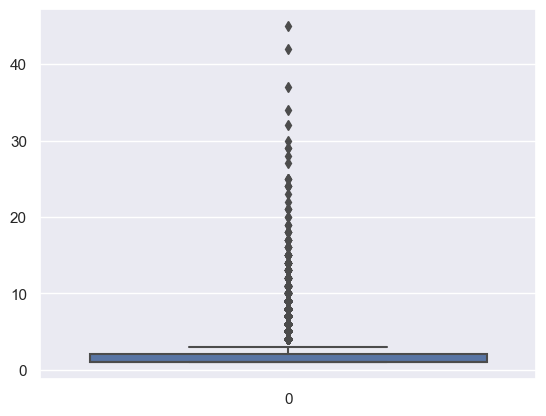

In [34]:
sns.boxplot(sales['total_products'])

Many outliers in the dataset, this could likely be from customers with multiple purchases due to bulk orders while most purchases are single orders. Will keep this as i also want to explore the data with regards to single and multiple purchase orders.

# EDA

In [35]:
#total revenue by date
sales.groupby('date')['Revenue'].sum()

date
2017-10-01    184461.75
2017-10-02    277139.81
2017-10-03    404668.73
2017-10-04    518277.91
2017-10-05    417629.27
2017-10-06    278427.63
2017-10-07    193745.02
2017-10-08    303668.93
2017-10-09    368157.15
2017-10-10    410093.47
2017-10-11    398130.40
2017-10-12    363019.74
2017-10-13    233484.84
2017-10-14    210113.74
2017-10-15    324666.84
2017-10-16    385685.33
2017-10-17    378273.63
2017-10-18    351829.01
2017-10-19    304497.09
2017-10-20    194325.11
2017-10-21    199548.32
Name: Revenue, dtype: float64

array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'user ID'}>,
        <Axes: title={'center': 'User_Birthday'}>],
       [<Axes: title={'center': 'Revenue'}>,
        <Axes: title={'center': 'total_products'}>,
        <Axes: title={'center': 'unique_product'}>],
       [<Axes: title={'center': 'time_of_day'}>,
        <Axes: title={'center': 'age'}>, <Axes: >]], dtype=object)

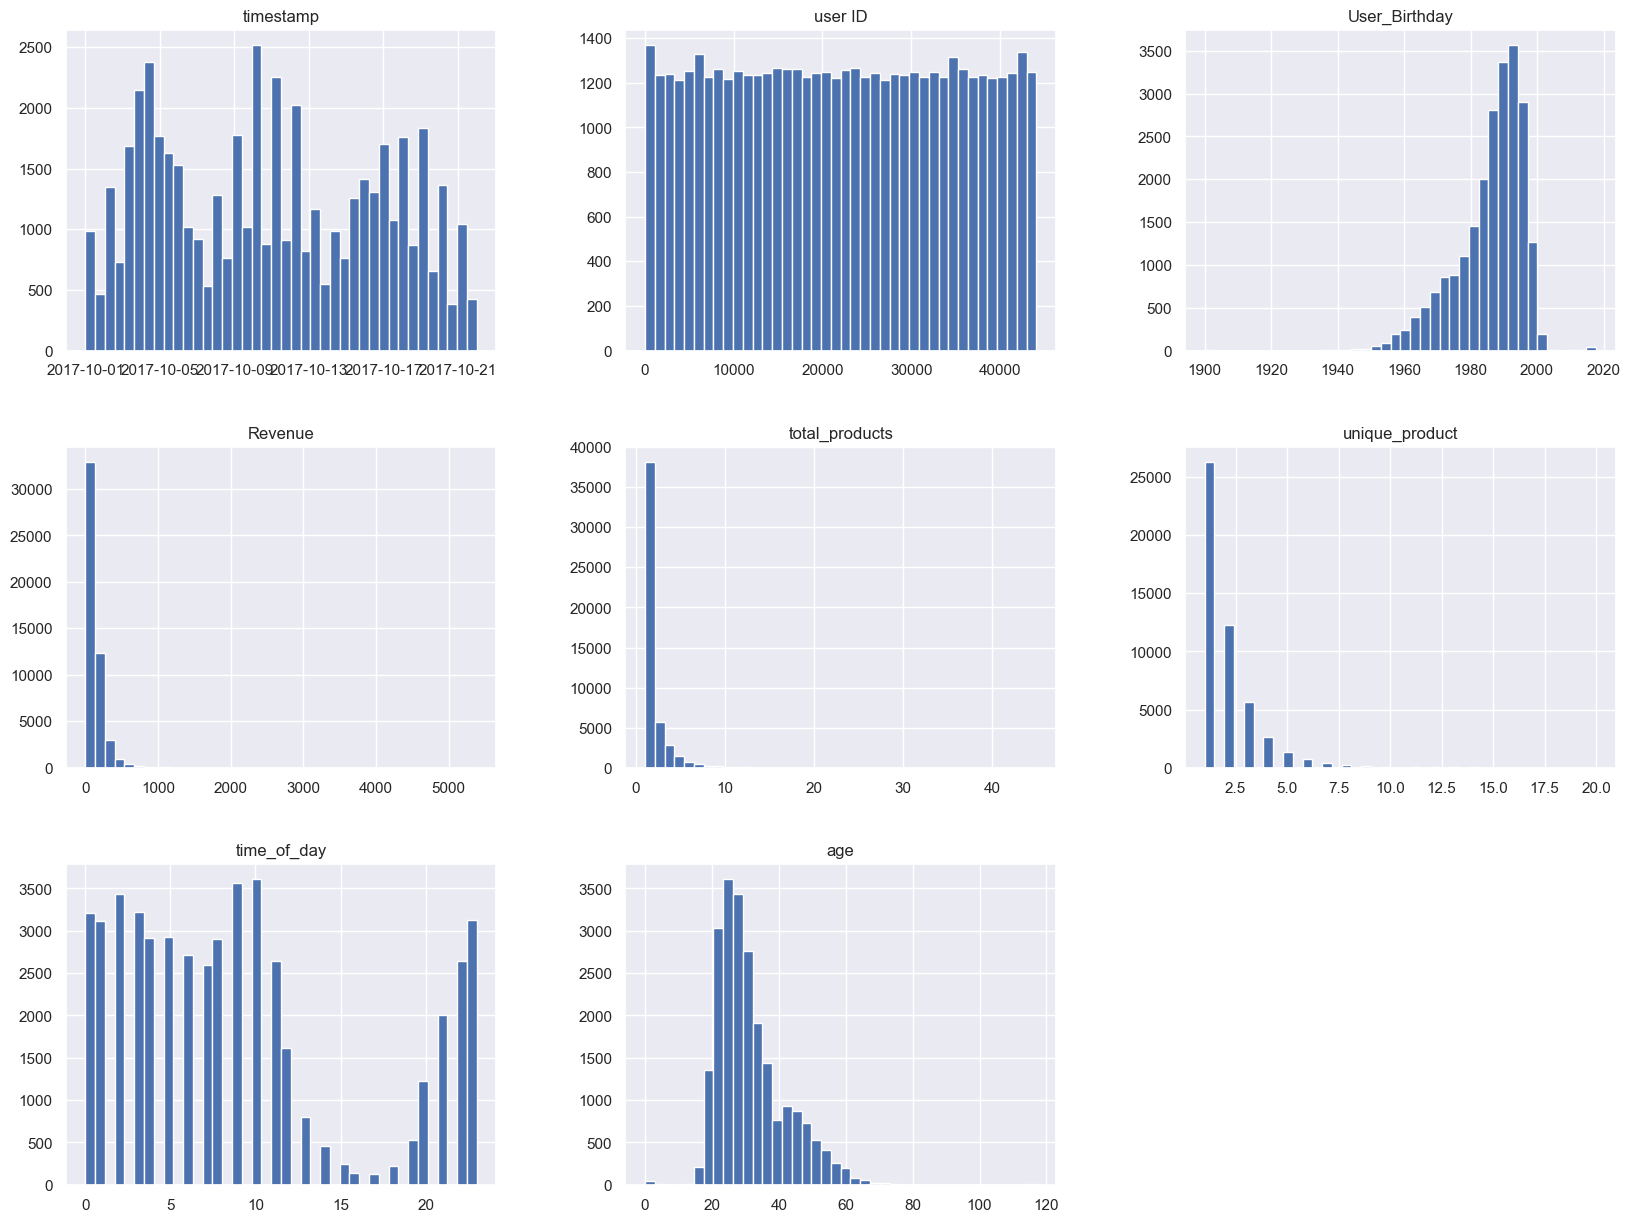

In [36]:
#Checking the distribution of each variable
sales.hist(bins=40, figsize=(20,15))

Some observations:
- 1) timestamp: there are 3 different peaks in revenue that looks consistent, this could be a trend
- 2) user_birthday: Most Users are born between 1990 to 2000, or most users who registered are born in those years
- 3) total_products:most users buy only 1 product, most users purchase one 1 product. This is outlying what i have stated earlier regarding outliers.
- 4) time_of_day: highest revenue falls on 9-10am, lowest revenue is between 4-7pm

# Overall view

For my analysis, I will be exploring several dimensions. The first will be an overview of sales with regards to attributes such as time dimension, region, payment type, single/multiple purchase. After that, I will explore the basket view looking at average orders, average revenue.

Total Sales and Total Revenue

In [37]:
total_sales = sales['total_products'].sum()
total_orders = sales['total_products'].count()

total_revenue = round(sales['Revenue'].sum()/1000000,1)

avg_revenue=round(sales['Revenue'].mean(),1)

avg_sales = round(sales['total_products'].mean(),1)


print("Overall Overview:")
print(f"Total Sales: {total_sales}")
print(f"Total Order: {total_orders}")
print(f"Total Revenue (in Millions): {total_revenue}")
print(f"Average Revenue per order: {avg_revenue}")
print(f"Average products per order:{avg_sales}")

Overall Overview:
Total Sales: 101332
Total Order: 49984
Total Revenue (in Millions): 6.7
Average Revenue per order: 134.0
Average products per order:2.0


Aggregating sales and products by date and revenue to plot

In [38]:
sns.set(style="darkgrid")

In [39]:
total_rev=sales.groupby('date')['Revenue'].agg(['mean','sum']).reset_index()
total_rev[['mean','sum']]=total_rev[['mean','sum']]/1000000
total_rev = total_rev.sort_values('date')

total_sale= sales.groupby('date')['total_products'].agg(['mean','sum']).reset_index()
total_sale=total_sale.sort_values('date')

Text(0, 0.5, 'Number of Products')

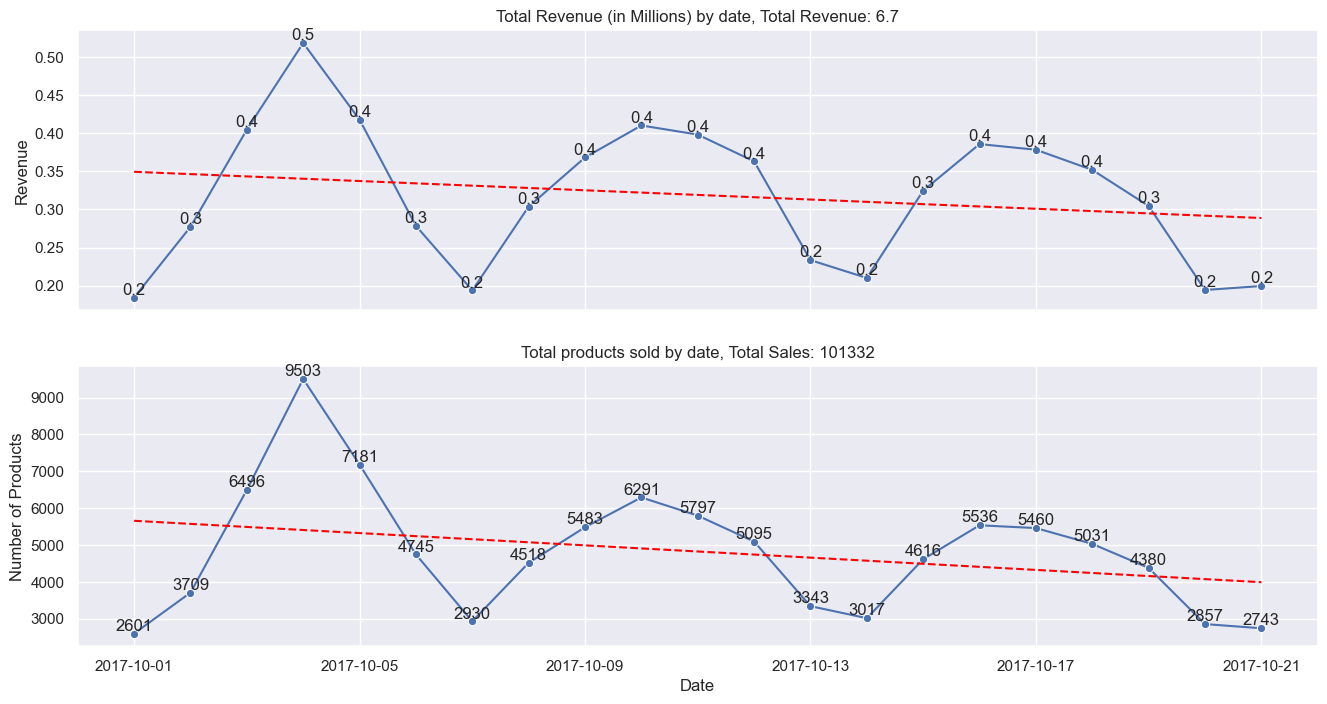

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)


sns.lineplot(x='date', y='sum', data=total_rev, marker='o', ax=ax[0])
coeffs_rev = np.polyfit(total_rev.index, total_rev['sum'], 1)
trend_line_rev = np.poly1d(coeffs_rev)
ax[0].plot(total_rev['date'], trend_line_rev(total_rev.index), linestyle='--', color='red', label='Trend Line')

for i, txt in enumerate(total_rev['sum']):
    ax[0].text(total_rev['date'][i], txt, f'{txt:.1f}', ha='center', va='bottom')


ax[0].set_title(f'Total Revenue (in Millions) by date, Total Revenue: {total_revenue:.1f}')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Revenue')

# Plot for Total Products Sold
sns.lineplot(x='date', y='sum', data=total_sale, marker='o', ax=ax[1])
coeffs_sale = np.polyfit(total_sale.index, total_sale['sum'], 1)
trend_line_sale = np.poly1d(coeffs_sale)
ax[1].plot(total_sale['date'], trend_line_sale(total_sale.index), linestyle='--', color='red', label='Trend Line')
for i, txt in enumerate(total_sale['sum']):
    ax[1].text(total_sale['date'][i], txt, f'{txt:.0f}', ha='center', va='bottom')

ax[1].set_title(f'Total products sold by date, Total Sales: {total_sales:.0f}')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Products')


- The peaks occurred on 2017/10/4, with Revenue reaching $0.5M.
- Peaks in Revenue and Sales occur approximately every 6 days.
- Both Revenue and Sales show a downward trend. Both follow the same trend

Total Sales by day of week and time of day

In [41]:
time_of_day_rev = sales.groupby('time_of_day')['Revenue'].agg(['mean', 'count','sum']).reset_index()
day_of_week_rev = sales.groupby('day_of_week')['Revenue'].agg(['mean', 'count','sum']).reset_index()
time_of_day_sale = sales.groupby('time_of_day')['total_products'].agg(['mean', 'count','sum']).reset_index()
day_of_week_sale = sales.groupby('day_of_week')['total_products'].agg(['mean', 'count','sum']).reset_index()

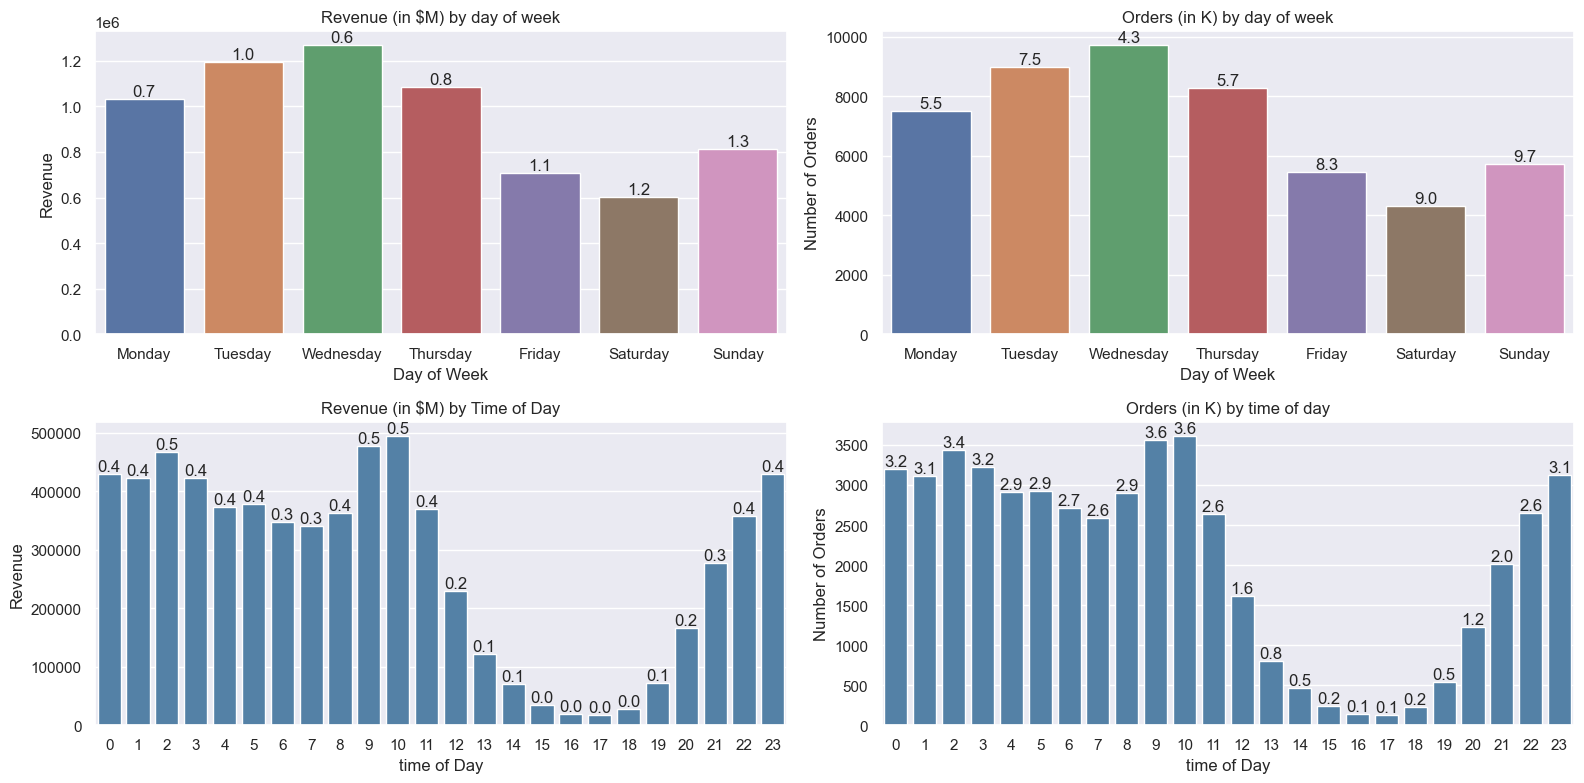

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.barplot(x=day_of_week_rev['day_of_week'], y=day_of_week_rev['sum'], order=day_order,ax=ax[0,0])
for p, txt in zip(ax[0, 0].patches, day_of_week_rev['sum']):
    ax[0, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/ 1e6:.1f}', ha='center', va='bottom')
ax[0,0].set_title('Revenue (in $M) by day of week')
ax[0,0].set_xlabel('Day of Week')
ax[0,0].set_ylabel('Revenue')

sns.barplot(x=day_of_week_sale['day_of_week'], y=day_of_week_sale['count'], order=day_order,ax=ax[0,1])
for p, txt in zip(ax[0, 1].patches, day_of_week_sale['count']):
    ax[0, 1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e3:.1f}', ha='center', va='bottom')
ax[0,1].set_title('Orders (in K) by day of week')
ax[0,1].set_xlabel('Day of Week')
ax[0,1].set_ylabel('Number of Orders')

sns.barplot(x=time_of_day_rev['time_of_day'], y=time_of_day_rev['sum'], ax=ax[1,0], color='steelblue')
for p, txt in zip(ax[1, 0].patches, time_of_day_rev['sum']):
    ax[1, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e6:.1f}', ha='center', va='bottom')

ax[1,0].set_title('Revenue (in $M) by Time of Day')
ax[1,0].set_xlabel('time of Day')
ax[1,0].set_ylabel('Revenue')

sns.barplot(x=time_of_day_sale['time_of_day'], y=time_of_day_sale['count'],ax=ax[1,1], color='steelblue')
for p, txt in zip(ax[1, 1].patches, time_of_day_sale['count']):
    ax[1, 1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e3:.1f}', ha='center', va='bottom')
ax[1,1].set_title('Orders (in K) by time of day')
ax[1,1].set_xlabel('time of Day')
ax[1,1].set_ylabel('Number of Orders')

plt.tight_layout()

- Day of Week:
Wednesday has the highest Revenue and Sales.
Saturday has the lowest Revenue and Sales.


- Time of Day:
Revenue and Sales peak at 9-10am
Revenue and Sales lowest at 4-5pm

In [43]:
sales['time_of_day'].value_counts(normalize=True)*100

10    7.220310
9     7.122279
2     6.874200
3     6.440061
0     6.412052
23    6.252001
1     6.221991
5     5.853873
4     5.829866
8     5.807859
6     5.431738
22    5.299696
11    5.285691
7     5.189661
21    4.015285
12    3.225032
20    2.446783
13    1.612516
19    1.070343
14    0.920294
15    0.482154
18    0.442141
16    0.284091
17    0.260083
Name: time_of_day, dtype: float64

Renenue by country/city/province

In [44]:
country_rev = sales.groupby('Country')['Revenue'].agg(['mean', 'count','sum']).reset_index().sort_values(by='sum', ascending=False)
city_rev = sales.groupby('City')['Revenue'].agg(['mean', 'count','sum']).reset_index().sort_values(by='sum', ascending=False)
top_15_cities = city_rev.nlargest(15, 'sum')
top_10_cities = city_rev.nlargest(10, 'sum')

country_prov_rev = sales.groupby('Country_Province')['Revenue'].agg(['mean', 'count','sum']).reset_index().sort_values(by='sum', ascending=False)
#day_of_week_sale = sales.groupby('day_of_week')['total_products'].agg(['mean', 'count','sum'])

In [45]:
sales['Country_Province'].value_counts(normalize=True)*100

NSW    47.467470
VIC    24.524059
QLD    11.453148
WA      6.460134
SA      6.130469
ACT     1.892848
TAS     1.672343
NT      0.399528
Name: Country_Province, dtype: float64

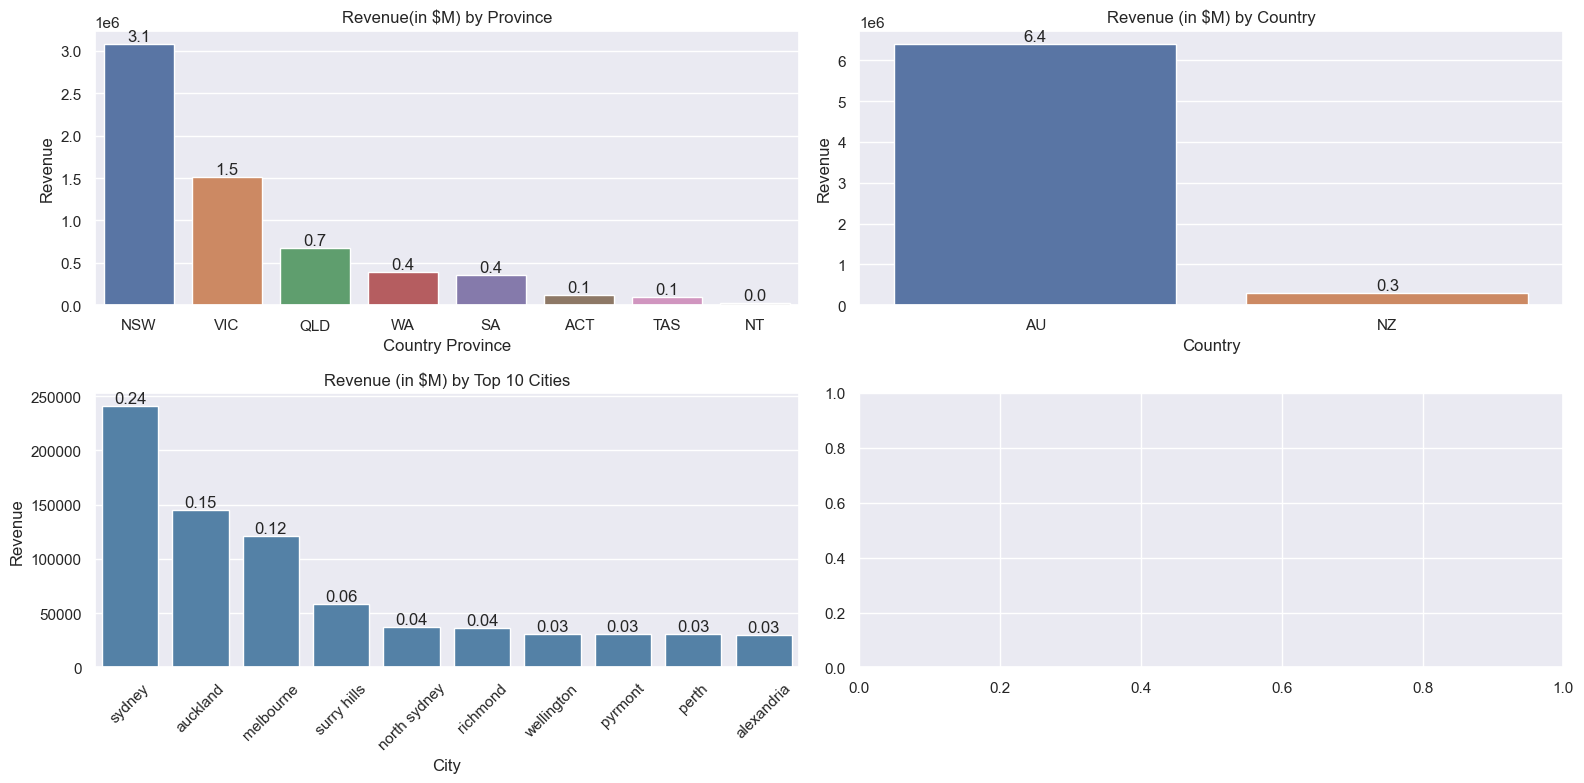

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

sns.barplot(x=country_prov_rev['Country_Province'], y=country_prov_rev['sum'], ax=ax[0, 0])
ax[0, 0].set_title('Revenue(in $M) by Province')
ax[0, 0].set_xlabel('Country Province')
ax[0, 0].set_ylabel('Revenue')

for p, txt in zip(ax[0, 0].patches, country_prov_rev['sum']):
    ax[0, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e6:.1f}', ha='center', va='bottom')

# Bar plot for Revenue by Country
sns.barplot(x=country_rev['Country'], y=country_rev['sum'], ax=ax[0, 1])
ax[0, 1].set_title('Revenue (in $M) by Country')
ax[0, 1].set_xlabel('Country')
ax[0, 1].set_ylabel('Revenue')

for p, txt in zip(ax[0, 1].patches, country_rev['sum']):
    ax[0, 1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e6:.1f}', ha='center', va='bottom')

# Bar plot for Revenue by top 10 Cities
sns.barplot(x=top_10_cities['City'], y=top_10_cities['sum'], ax=ax[1, 0], color='steelblue')
ax[1, 0].set_title('Revenue (in $M) by Top 10 Cities')
ax[1, 0].set_xlabel('City')
ax[1, 0].set_ylabel('Revenue')
ax[1, 0].set_xticklabels(labels=top_10_cities['City'], rotation=45)

for p, txt in zip(ax[1, 0].patches, top_10_cities['sum']):
    ax[1, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e6:.2f}', ha='center', va='bottom')

plt.tight_layout()

- Top 3 Revenue% Province:
NSW - 49%
VIC - 23%
QLD - 11%

- Top Revenue% Country
AU - 95%

- Top 3 Revenue% City
Sydney - 3.5%
Auckland - 2.2%
Melbourne- 1.79%


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'sydney'),
  Text(1, 0, 'auckland'),
  Text(2, 0, 'melbourne'),
  Text(3, 0, 'surry hills'),
  Text(4, 0, 'north sydney'),
  Text(5, 0, 'richmond'),
  Text(6, 0, 'wellington'),
  Text(7, 0, 'pyrmont'),
  Text(8, 0, 'perth'),
  Text(9, 0, 'alexandria')])

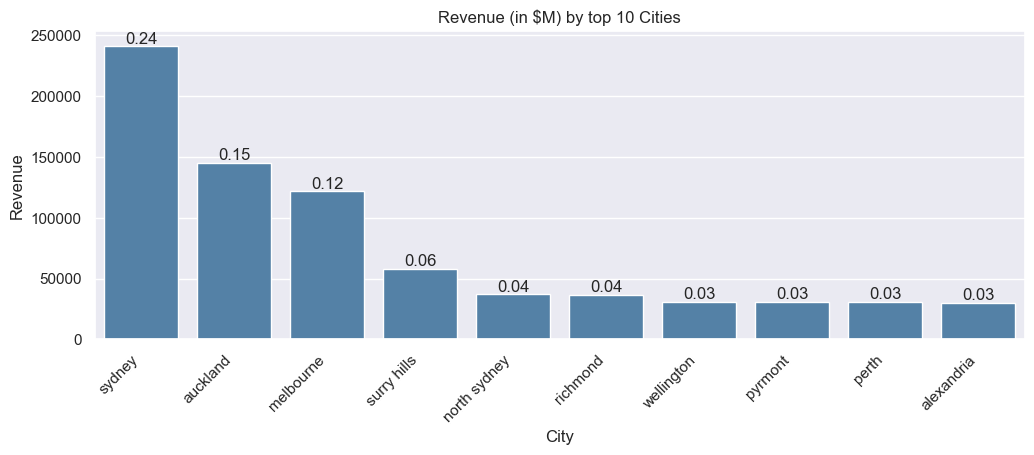

In [47]:
plt.figure(figsize=(12, 4))

sns.barplot(x=top_10_cities['City'], y=top_10_cities['sum'], color='steelblue')
for p, txt in zip(plt.gca().patches, top_10_cities['sum']):
    plt.gca().text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e6:.2f}', ha='center', va='bottom')
plt.title('Revenue (in $M) by top 10 Cities')
plt.xlabel('City')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')

Orders by Country/city/province

In [48]:
country_sales = sales.groupby('Country')['total_products'].agg(['mean', 'count','sum']).reset_index().reset_index().sort_values(by='count', ascending=False)
city_sales = sales.groupby('City')['total_products'].agg(['mean', 'count','sum']).reset_index().reset_index().sort_values(by='count', ascending=False)
top_15_cities_sale = city_sales.nlargest(15, 'count')
top_10_cities_sale = city_sales.nlargest(10, 'count')

country_prov_sales = sales.groupby('Country_Province')['total_products'].agg(['mean', 'count','sum']).reset_index().reset_index().sort_values(by='count', ascending=False)

In [49]:
top_10_cities_sale

,index,City,mean,count,sum
3776,3776,sydney,2.261890,1661,3757
150,150,auckland,1.652355,1444,2386
2483,2483,melbourne,2.140732,874,1871
3764,3764,surry hills,2.327128,376,875
829,829,christchurch,1.603175,315,505
4218,4218,wellington,1.689769,303,512
2930,2930,north sydney,1.996516,287,573
18,18,adelaide,2.114155,219,463
3338,3338,richmond,2.219178,219,486
3145,3145,perth,2.037559,213,434


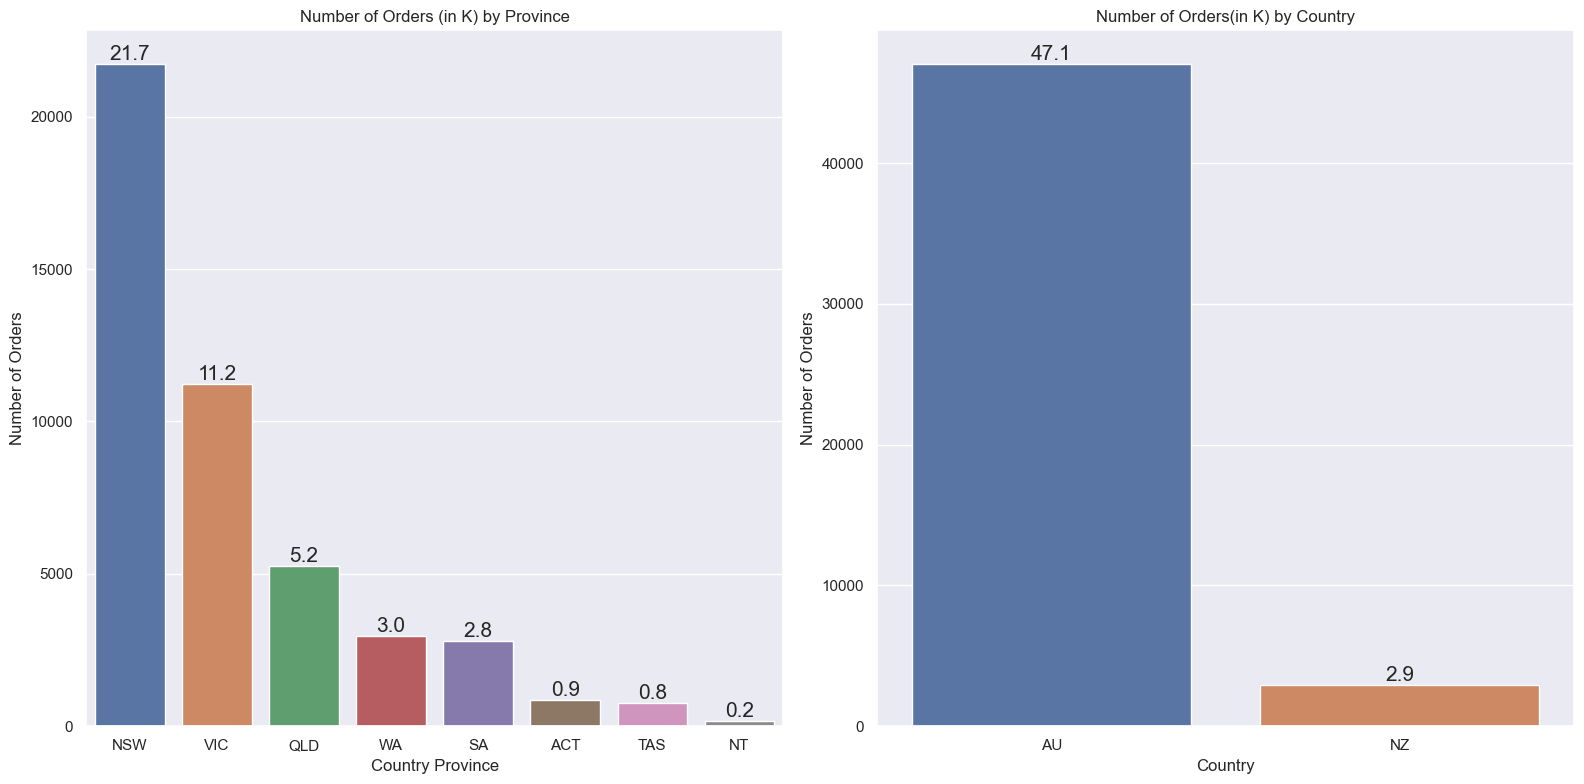

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=country_prov_sales['Country_Province'], y=country_prov_sales['count'], ax=ax[0])
for p, txt in zip(ax[0].patches, country_prov_sales['count']):
    ax[0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e3:.1f}', 
            ha='center', va='bottom', fontsize=15)
ax[0].set_title('Number of Orders (in K) by Province')
ax[0].set_xlabel('Country Province')
ax[0].set_ylabel('Number of Orders')

sns.barplot(x=country_sales['Country'], y=country_sales['count'],ax=ax[1])
for p, txt in zip(ax[1].patches, country_sales['count']):
    ax[1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e3:.1f}', ha='center', va='bottom', fontsize=15)
ax[1].set_title('Number of Orders(in K) by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Number of Orders')

plt.tight_layout()

- Top 3 orders by Province:
NSW - 47%
VIC - 24%
QLD - 11%

- Top orders by Country
AU - 94%


Text(0, 0.5, 'Number of Orders')

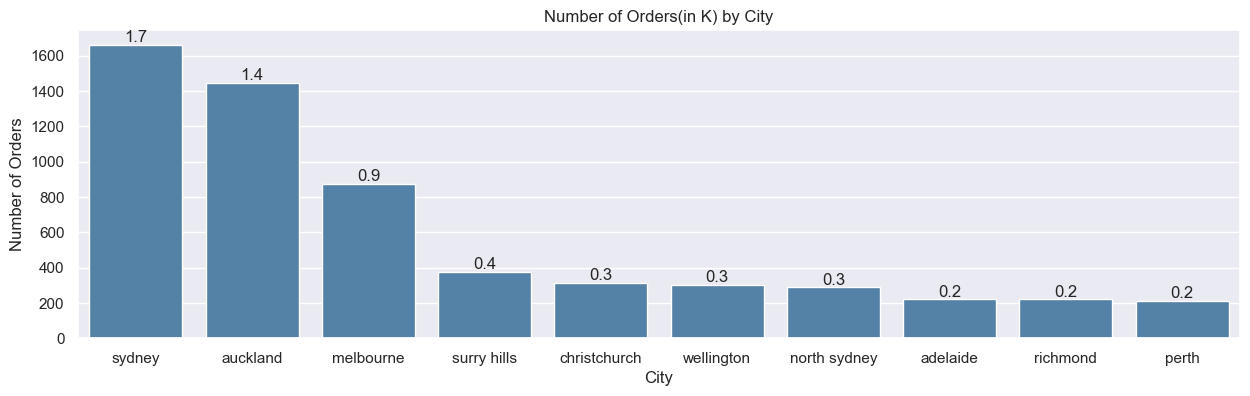

In [51]:
plt.figure(figsize=(15, 4))

sns.barplot(x=top_10_cities_sale['City'], y=top_10_cities_sale['count'],color='steelblue')
for p, txt in zip(plt.gca().patches, top_10_cities_sale['count']):
    plt.gca().text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e3:.1f}', ha='center', va='bottom')
plt.title('Number of Orders(in K) by City')
plt.xlabel('City')
plt.ylabel('Number of Orders')

- Top 3 orders by City
Sydney - 3.2%
Auckland - 2.8%
Melbourne - 1.8%


Revenue & Orders by Payment type

In [52]:
payment_type_rev = sales.groupby('Payment_Type')['Revenue'].agg(['mean', 'count','sum']).reset_index()
payment_type_sale = sales.groupby('Payment_Type')['total_products'].agg(['mean', 'count','sum']).reset_index()


In [53]:
payment_type_rev

,Payment_Type,mean,count,sum
0,NoPayment,0.000000,984,0.00
1,cc@braintree,140.097765,23763,3329143.20
2,paypal@braintree,128.102615,12059,1544789.44
3,pbi@afterpay,138.557526,13178,1825911.08


Text(0, 0.5, 'Number of Orders')

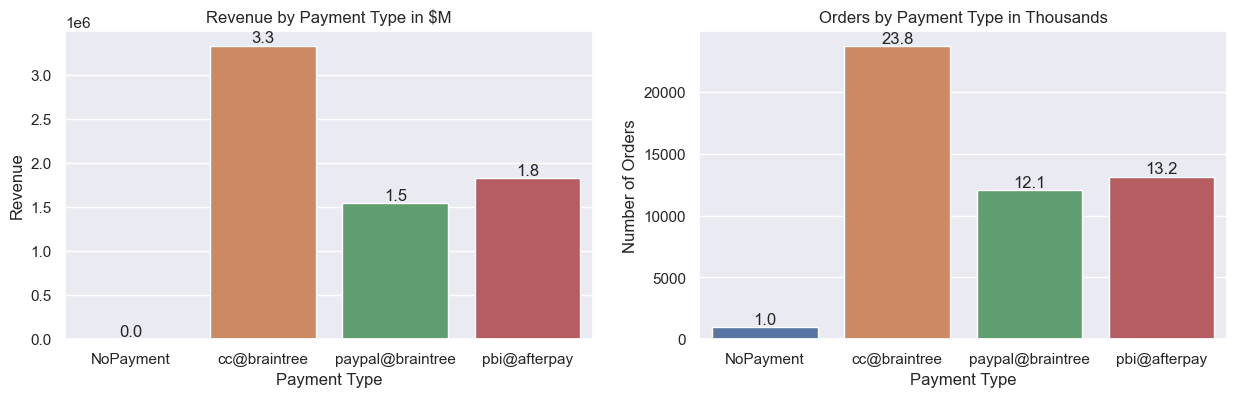

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

sns.barplot(x=payment_type_rev['Payment_Type'], y=payment_type_rev['sum'], ax=ax[0],errorbar=None)
for p, txt in zip(ax[0].patches, payment_type_rev['sum']):
    ax[0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e6:.1f}', ha='center', va='bottom')
ax[0].set_title('Revenue by Payment Type in $M')
ax[0].set_xlabel('Payment Type')
ax[0].set_ylabel('Revenue')

sns.barplot(x=payment_type_sale['Payment_Type'], y=payment_type_sale['count'],ax=ax[1], errorbar=None)
for p, txt in zip(ax[1].patches, payment_type_sale['count']):
    ax[1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e3:.1f}', ha='center', va='bottom')
ax[1].set_title('Orders by Payment Type in Thousands')
ax[1].set_xlabel('Payment Type')
ax[1].set_ylabel('Number of Orders')


- Highest revenue and orders by payment type:
1. cc@braintree
2. pbi@afterpay
3. paypal@braintree


Amount paid using cc@braintree is 120% more than paypal@braintree and 100% more than pbi@afterpay

Number of orders using cc@braintree is 96% more than paypal@braintree and 80% more than pbi@afterpay

Strong customer base and usage with cc@braintree



Orders and Revenue by Gender

In [55]:
gender_rev = sales.groupby('User_Gender')['Revenue'].agg(['mean', 'count','sum']).reset_index()
gender_sales = sales.groupby('User_Gender')['total_products'].agg(['mean', 'count','sum']).reset_index()


In [56]:
sales['User_Gender'].value_counts(normalize=True)

female    0.841303
male      0.158697
Name: User_Gender, dtype: float64

Text(0, 0.5, 'Number of Orders')

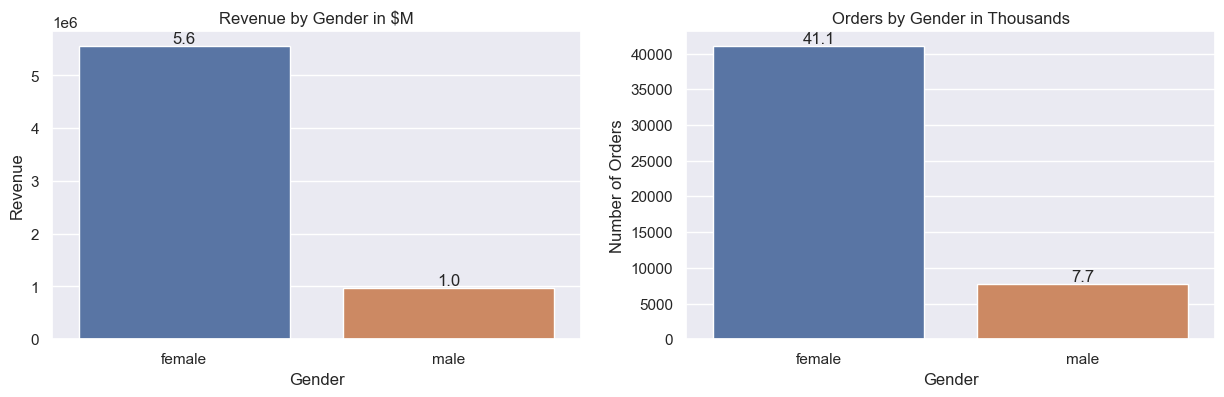

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

sns.barplot(x=gender_rev['User_Gender'], y=gender_rev['sum'], ax=ax[0],errorbar=None)
for p, txt in zip(ax[0].patches, gender_rev['sum']):
    ax[0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e6:.1f}', ha='center', va='bottom')
ax[0].set_title('Revenue by Gender in $M')
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('Revenue')

sns.barplot(x=gender_sales['User_Gender'], y=gender_sales['count'],ax=ax[1], errorbar=None)
for p, txt in zip(ax[1].patches, gender_sales['count']):
    ax[1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e3:.1f}', ha='center', va='bottom')
ax[1].set_title('Orders by Gender in Thousands')
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Number of Orders')

‘User_Gender’ column is missing 1174 rows of data

Highest revenue and sales by Gender:
Female- 84%
Male - 16%

There is room to cater for the different needs of both genders


#Revenue by Age

In [58]:
age_rev = sales.groupby('age_category')['Revenue'].agg(['mean', 'count','sum']).reset_index()
age_sales = sales.groupby('age_category')['total_products'].agg(['mean', 'count','sum']).reset_index()


Text(0, 0.5, 'Number of Orders')

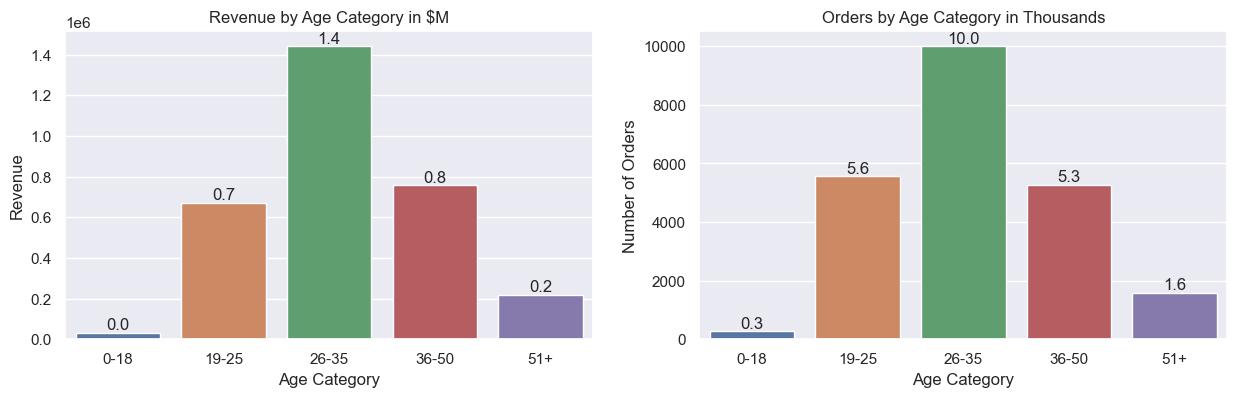

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

sns.barplot(x=age_rev['age_category'], y=age_rev['sum'], ax=ax[0],errorbar=None)
for p, txt in zip(ax[0].patches, age_rev['sum']):
    ax[0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e6:.1f}', ha='center', va='bottom')
ax[0].set_title('Revenue by Age Category in $M')
ax[0].set_xlabel('Age Category')
ax[0].set_ylabel('Revenue')

sns.barplot(x=age_sales['age_category'], y=age_sales['count'],ax=ax[1], errorbar=None)
for p, txt in zip(ax[1].patches, age_sales['count']):
    ax[1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{txt/1e3:.1f}', ha='center', va='bottom')
ax[1].set_title('Orders by Age Category in Thousands')
ax[1].set_xlabel('Age Category')
ax[1].set_ylabel('Number of Orders')

There are 27275 missing rows for user birthday, but this a big enough sample.

1. Highest Revenue: 26-35 
2. Highest orders: 26-35


Product seems to target mainly young adults, middle-age and seniors 


# Basket View

Average revenue per order

In [60]:
avg_unique_product_per_order = sales.groupby('timestamp')['unique_product'].mean().mean()
avg_revenue_per_order = sales.groupby('timestamp')['Revenue'].mean().mean()
print(f"Avg. Unique Quantity per Order: {avg_unique_product_per_order:.2f}, Avg. Revenue per Order: ${avg_revenue_per_order:.2f}")

Avg. Unique Quantity per Order: 1.97, Avg. Revenue per Order: $134.13


Single vs Multiple purchases

In [61]:
sales['Single/Multiple'].value_counts(normalize=True)*100

Single      51.050336
Multiple    48.949664
Name: Single/Multiple, dtype: float64

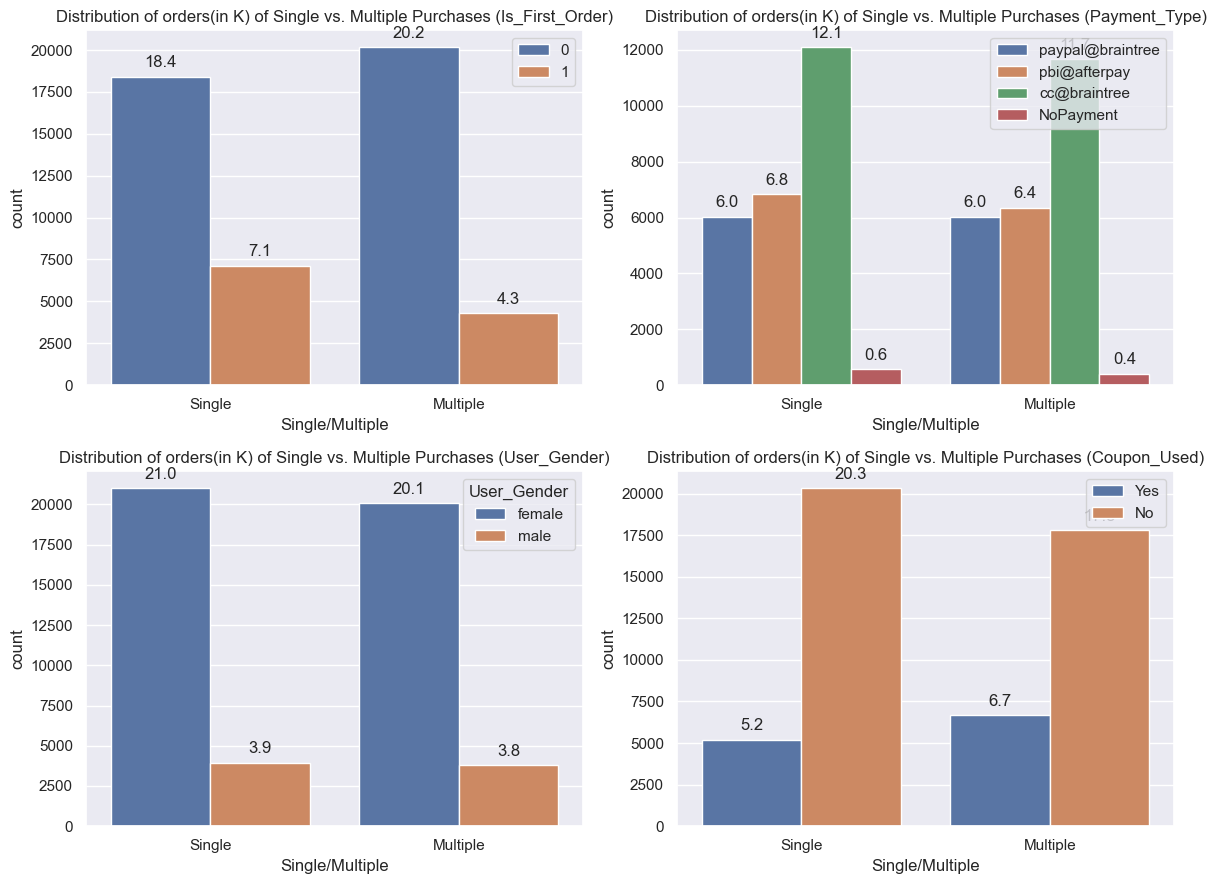

In [62]:

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

# Plot 1: Is_First_Order
sns.countplot(x='Single/Multiple', hue='Is_First_Order', data=sales, ax=axes[0, 0])
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height()/1e3:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 5),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[0, 0].set_title('Distribution of orders(in K) of Single vs. Multiple Purchases (Is_First_Order)')
axes[0,0].legend(loc='upper right')

# Plot 2: Payment_Type
sns.countplot(x='Single/Multiple', hue='Payment_Type', data=sales, ax=axes[0, 1])
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height()/1e3:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 5),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[0, 1].set_title('Distribution of orders(in K) of Single vs. Multiple Purchases (Payment_Type)')
axes[0,1].legend(loc='upper right')

# Plot 3: User_Gender
sns.countplot(x='Single/Multiple', hue='User_Gender', data=sales, ax=axes[1, 0])
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height()/1e3:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 5),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[1, 0].set_title('Distribution of orders(in K) of Single vs. Multiple Purchases (User_Gender)')

# Plot 4: Coupon_Used
sns.countplot(x='Single/Multiple', hue='coupon_used', data=sales, ax=axes[1, 1])
for p in axes[1, 1].patches:
    axes[1, 1].annotate(f'{p.get_height()/1e3:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 5),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[1, 1].set_title('Distribution of orders(in K) of Single vs. Multiple Purchases (Coupon_Used)')
axes[1,1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()



1. First orders:
- Same proportion of multiple and single purchases for first orders
- Proportion of multiple purchases is 104% than single purchases for first orders
2. Payment Type:
- Proportion of Users with Multiple order purchases use cc@braintree 87.47% more than single Purchases
3. Gender:
- Proportion of Female vs Male are similar
4. Coupon:
- Higher proportion of users who use coupons to purchase multiple items compared to Single items


In [63]:
city_sales_s_m = sales.groupby(['City', 'Single/Multiple'])['total_products'].agg(['mean', 'count','sum']).reset_index()
top_10_cities_sale = city_sales_s_m.nlargest(10, 'sum')

In [64]:
top_10_cities_sale 

,City,Single/Multiple,mean,count,sum
6117,sydney,Multiple,3.229787,940,3036
245,auckland,Multiple,2.577889,597,1539
4028,melbourne,Multiple,3.134904,467,1464
246,auckland,Single,1.000000,847,847
6118,sydney,Single,1.000000,721,721
6097,surry hills,Multiple,3.507538,199,698
4758,north sydney,Multiple,2.932432,148,434
4029,melbourne,Single,1.000000,407,407
5406,richmond,Multiple,3.321739,115,382
83,alexandria,Multiple,3.462264,106,367


In [65]:
sales['Country'].value_counts(normalize=True)

AU    0.941721
NZ    0.058279
Name: Country, dtype: float64

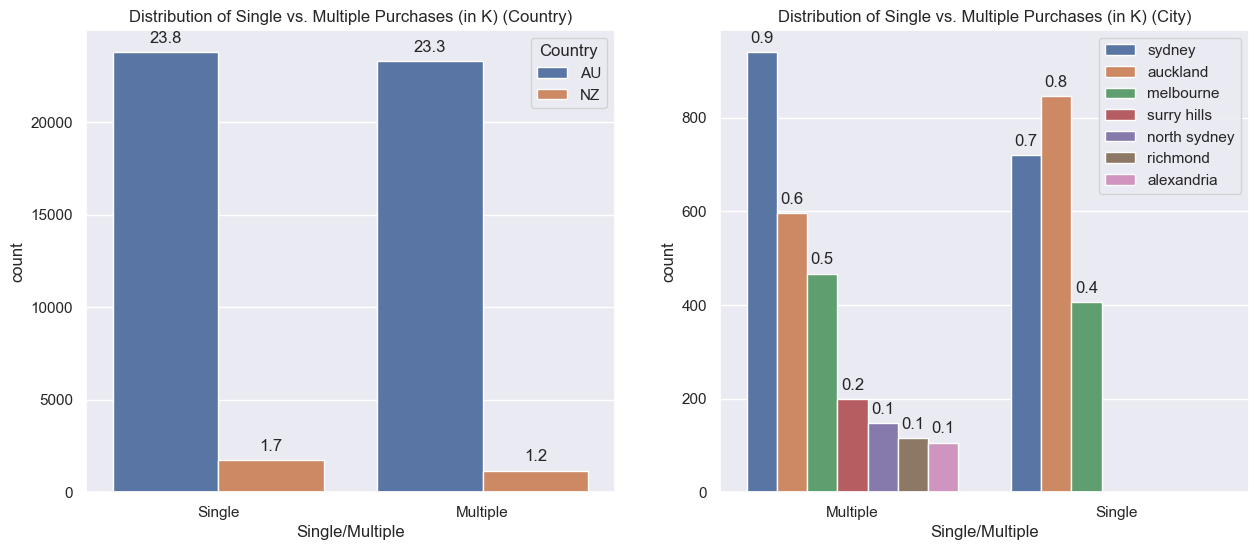

In [66]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot 1: Is_First_Order
sns.countplot(x='Single/Multiple', hue='Country', data=sales, ax=axes[0])
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())/1e3:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[0].set_title('Distribution of Single vs. Multiple Purchases (in K) (Country)')

# Plot 2: Payment_Type

sns.barplot(x='Single/Multiple', y='count', hue='City', data=top_10_cities_sale, ax=axes[1])
for p in axes[1].patches:
    height = p.get_height()
    if not np.isnan(height):
        axes[1].annotate(f'{int(height)/1e3:,.1f}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[1].set_title('Distribution of Single vs. Multiple Purchases (in K) (City)')
axes[1].legend(loc='upper right')

For City - Comparison based on top 10 cities by Revenue for Single and Multiple Purchase

1. Country:
- 94% of sales are from AU.
- Proportions of single/multiple purchase similar for both countries.

2. City:
- Single Purchases only come from 3 cities: Sydney, Auckland, Melbourne.
- Multiple purchases includes Surry hills, North Sydney, Alexandria and Richmond.


In [67]:
first_order_rev = sales.groupby(['Single/Multiple','Is_First_Order'])['Revenue'].agg(['mean', 'count','sum']).reset_index()
payment_type_rev = sales.groupby(['Single/Multiple','Payment_Type'])['Revenue'].agg(['mean', 'count','sum']).reset_index()
gender_rev = sales.groupby(['Single/Multiple','User_Gender'])['Revenue'].agg(['mean', 'count','sum']).reset_index()
coupon_used_rev = sales.groupby(['Single/Multiple','coupon_used'])['Revenue'].agg(['mean', 'count','sum']).reset_index()


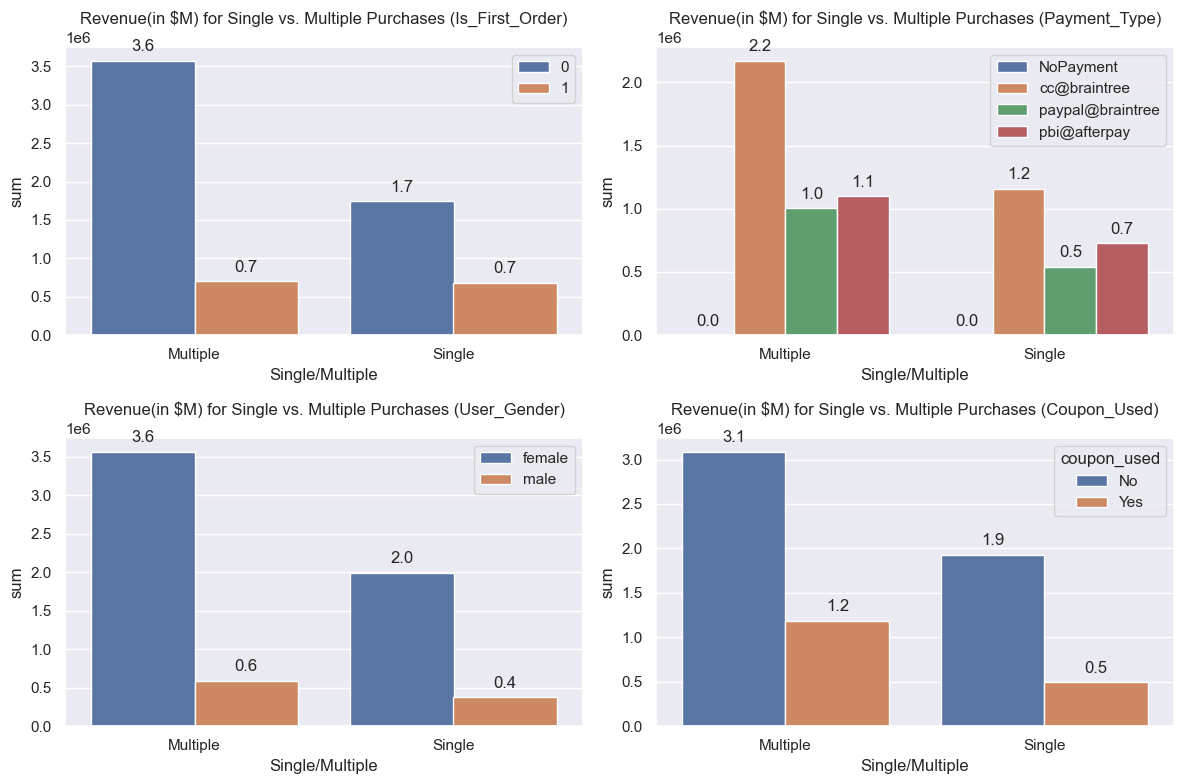

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot 1: Is_First_Order
sns.barplot(x='Single/Multiple', y='sum',hue='Is_First_Order', data=first_order_rev, ax=axes[0,0])
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height()/1e6:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 500),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[0,0].set_title('Revenue(in $M) for Single vs. Multiple Purchases (Is_First_Order)')
axes[0,0].legend(loc='upper right')

# Plot 2: Payment_Type
sns.barplot(x='Single/Multiple',y='sum', hue='Payment_Type', data=payment_type_rev, ax=axes[0, 1])
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height()/1e6:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 500),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[0, 1].set_title('Revenue(in $M) for Single vs. Multiple Purchases (Payment_Type)')
axes[0,1].legend(loc='upper right')

# Plot 3: User_Gender
sns.barplot(x='Single/Multiple', y='sum',hue='User_Gender', data=gender_rev, ax=axes[1, 0])
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height()/1e6:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 500),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axes[1, 0].set_title('Revenue(in $M) for Single vs. Multiple Purchases (User_Gender)')
axes[1,0].legend(loc='upper right')

# Plot 4: Coupon_Used
sns.barplot(x='Single/Multiple', y='sum', hue='coupon_used', data=coupon_used_rev, ax=axes[1, 1])
for p in axes[1, 1].patches:
    axes[1, 1].annotate(f'{p.get_height()/1e6:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 500),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axes[1, 1].set_title('Revenue(in $M) for Single vs. Multiple Purchases (Coupon_Used)')

# Adjust layout
plt.tight_layout()

1. First orders(1=first order):
- Similar revenue for multiple and single purchases.
- Revenue of multiple purchases is 117% more than single purchases for non-first orders
2. Payment Type:
- Revenue from multiple purchases using cc@braintree is 83.3% higher compared to single purchases.
- Revenue from multiple purchases using paypal@braintree is twice of  single purchases.
3. Gender:
- Revenue for multiple purchases for female users is 80% higher than Single.
4. Coupon:
- Revenue for multiple purchases with coupons is 140% more than single purchases.

In [69]:
city_rev_s_m = sales.groupby(['City', 'Single/Multiple'])['Revenue'].agg(['mean', 'count','sum']).reset_index()
country_rev_s_m = sales.groupby(['Country', 'Single/Multiple'])['Revenue'].agg(['mean', 'count','sum']).reset_index()

top_10_cities_rev = city_rev_s_m.nlargest(10, 'sum')


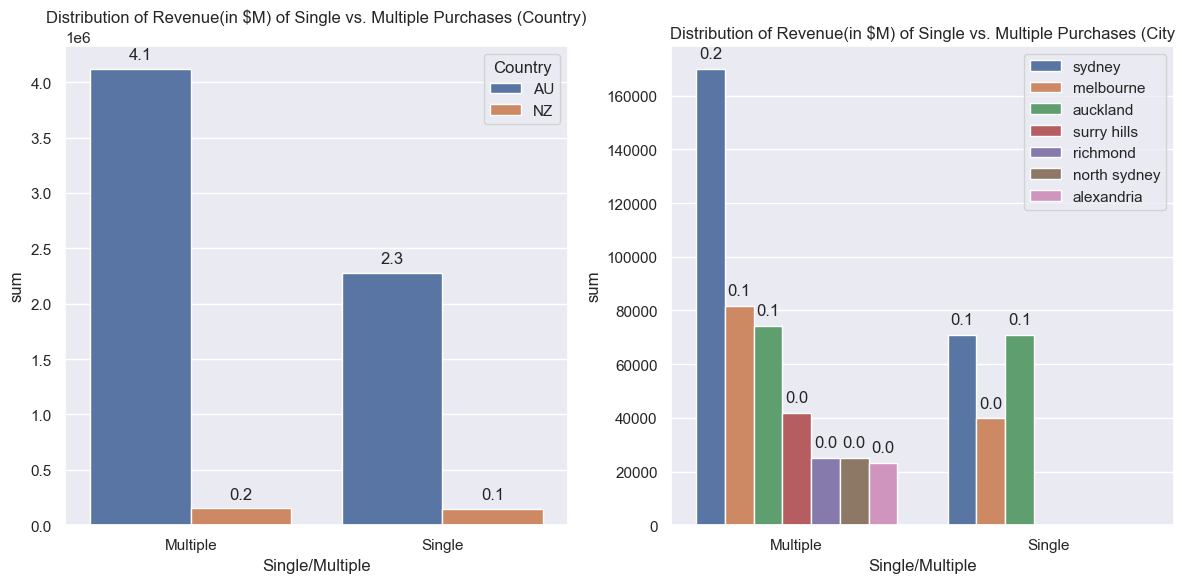

In [70]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Country
sns.barplot(x='Single/Multiple', y='sum', hue='Country', data=country_rev_s_m, ax=axes[0])
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()/1e6:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 500),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plot 2: Single/Multiple vs. City
axes[0].set_title('Distribution of Revenue(in $M) of Single vs. Multiple Purchases (Country)')

# Plot 2: City

sns.barplot(x='Single/Multiple', y='sum', hue='City', data=top_10_cities_rev, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()/1e6:,.1f}', (p.get_x() + p.get_width() / 2., p.get_height() + 500),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[1].set_title('Distribution of Revenue(in $M) of Single vs. Multiple Purchases (City')
axes[1].legend(loc='upper right')
plt.tight_layout()
plt.show()


For City - Comparison based on top 10 cities by Revenue for Single and Multiple Purchase

1. Country:
- 94% of sales are from AU.
- In AU, 80% more multiple purchases than Single

2. City(Top 10 Revenue):
- Single Purchases only come from 3 cities: Sydney, Auckland, Melbourne.
- Multiple purchases includes Surry hills, North Sydney, Alexandria and Richmond.
- Sydney, Melbourne, Auckland has the highest revenue for both multiple and single purchases.


User Type

In [71]:
sales['user_type'].value_counts(normalize=True)*100

Not Registered    54.567462
Registered        45.432538
Name: user_type, dtype: float64

In [72]:
usertype_rev_s_m = sales.groupby(['user_type', 'Single/Multiple'])['Revenue'].agg(['mean', 'count','sum']).reset_index()
usertype_sales_s_m = sales.groupby(['user_type', 'Single/Multiple'])['total_products'].agg(['mean', 'count','sum']).reset_index()

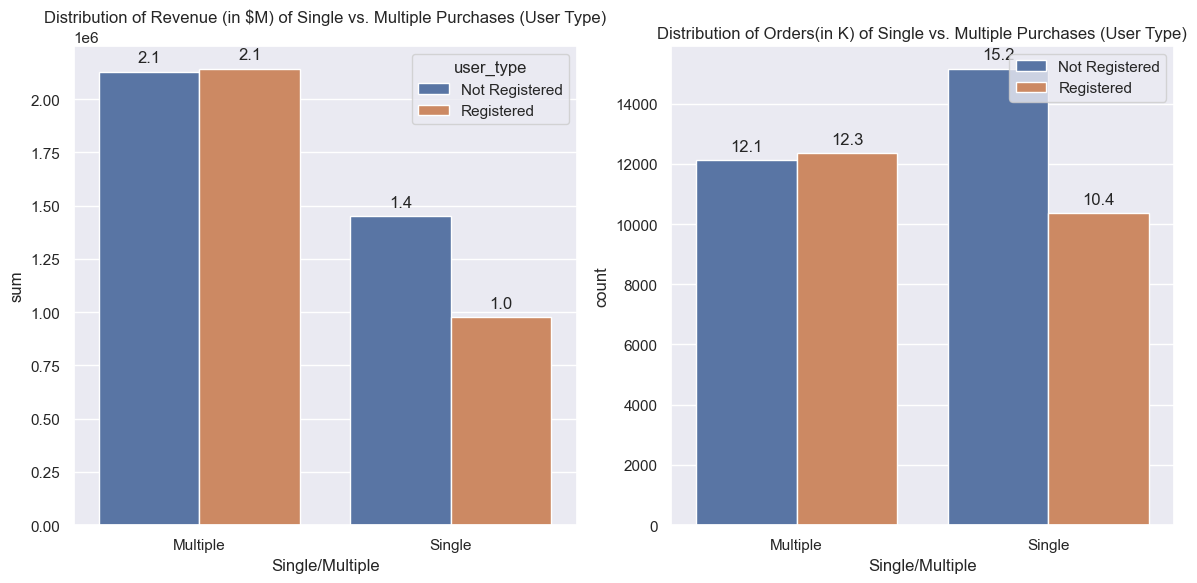

In [73]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Country
sns.barplot(x='Single/Multiple', y='sum', hue='user_type', data=usertype_rev_s_m, ax=axes[0])
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{int(height)/1e6:,.1f}', (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[0].set_title('Distribution of Revenue (in $M) of Single vs. Multiple Purchases (User Type)')

# Plot 2: City

sns.barplot(x='Single/Multiple', y='count', hue='user_type', data=usertype_sales_s_m, ax=axes[1])
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{int(height)/1e3:,.1f}', (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[1].set_title('Distribution of Orders(in K) of Single vs. Multiple Purchases (User Type)')
axes[1].legend(loc='upper right')

plt.tight_layout()

User Type:
- Revenue and sales for single purchases by non-registered users are 48% more than those by registered users.

- Non Registered users, for single purchases, contribute significantly more than registered users. Potential to convert to registered user and enhance revenue

- The user registration status does not seem to significantly impact the proportion of revenue and sales for multiple purchases.


# Product Affinity

- here I do a simple analysis on product combinations likely to sell together.

In [74]:
sales['Product_ID'].value_counts()

VA142SH06DYV                                           147
BI090SH74FBL                                           115
AD660SH72MVR                                            84
BI090SH95XBG                                            74
AD660SH78MVL                                            63
                                                      ... 
NU481AA82OXD,AB823AA60SRB                                1
SA041AC45KRY                                             1
CH336SA11ZEI,AT116AA10YVT,AD776SA76MZR,PU462SF31AJG      1
MN111AA32UGP,MN111AA69FGS                                1
BO376US11SBO,RA075AC69NRE,LE893AA76XHR                   1
Name: Product_ID, Length: 36018, dtype: int64

In [75]:
sales['Product_List'] = sales['Product_ID'].str.split(',')
sales['Product_List'] = sales['Product_List'].apply(lambda x: sorted(x))



In [76]:
combinations_prod = sales['Product_List'].explode().reset_index().groupby('index')['Product_List'].apply(tuple).reset_index()


In [77]:
combination_counts = combinations_prod['Product_List'].value_counts().reset_index(name='Count')


In [78]:
combination_counts

,index,Count
0,"(VA142SH06DYV,)",147
1,"(BI090SH74FBL,)",115
2,"(AD660SH72MVR,)",84
3,"(BI090SH95XBG,)",74
4,"(AD660SH78MVL,)",63
...,...,...
35918,"(AT763CA89ZVM,)",1
35919,"(BU421AC31XSA, MO658US27WBO)",1
35920,"(DE439AA83NXK, LA117AA45MHI, TO336AA86GNP)",1
35921,"(MA646AA62KDX,)",1


In [79]:
filtered_combinations = combination_counts[combination_counts['index'].apply(len) > 1]

In [80]:
top_combinations = filtered_combinations.head(10)
top_combinations


,index,Count
365,"(NI126AA40TEL, NI126AA41TEK)",8
634,"(CA221AC27YSE, CA221AC29UPY)",6
821,"(ON866AA63CDC, ON866AA65CDA)",5
854,"(NI126SA70ZTL, NI126SA78QUZ)",5
907,"(ON866AA63CDC, ON866AA64CDB)",5
1055,"(MI202AA30ORL, MI202AA31ORK)",4
1145,"(LY151AA05YNM, LY151AA23YMU)",4
1164,"(AT049AA65FBY, AT049AA68FBV)",4
1189,"(CA221AC27UQA, CA221AC29UPY)",4
1268,"(JE811AA48XFV, JE811AA49XFU)",4


# Segmentation


1) High-Value Customers: Customers in the top 20% of revenue.

- Characteristics: Regular high spenders, frequent purchasers, strong brand loyalty.


2) Medium-Value Customers: Customers in the 20-80% range of revenue.

- Characteristics: Moderate spenders, occasional purchasers.

3) Low-Value Customers: Customers in the bottom 20% of revenue.
- Characteristics: Infrequent purchasers, lower spending.

In [81]:
percentiles = [0, 0.2, 0.8, 1]
segment_labels = ['Low-Value Customers', 'Medium-Value Customers', 'High-Value Customers']

sales['Revenue_Segment'] = pd.qcut(sales['Revenue'], q=percentiles, labels=segment_labels)

# Explore the segments
segment_stats = sales.groupby('Revenue_Segment')['Revenue'].describe()

In [82]:
print(segment_stats)

                          count        mean         std     min      25%  \
Revenue_Segment                                                            
Low-Value Customers      9999.0   35.963908   18.226646    0.00   25.975   
Medium-Value Customers  29988.0  105.269878   34.691503   56.35   75.175   
High-Value Customers     9997.0  318.436280  194.256212  181.80  216.360   

                           50%      75%      max  
Revenue_Segment                                   
Low-Value Customers      42.70   51.765    56.34  
Medium-Value Customers   98.18  130.910   181.79  
High-Value Customers    261.82  351.760  5387.71  


In [83]:
revenue_segment= sales.groupby(['Revenue_Segment'])['Revenue'].agg(['mean', 'count','sum']).reset_index()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


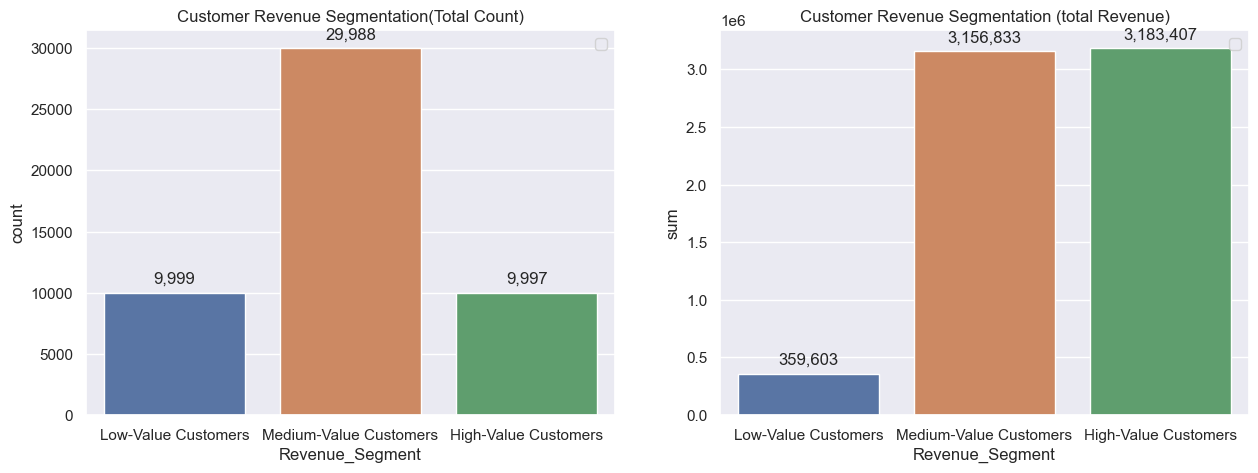

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot 1: Is_First_Order
sns.barplot(x='Revenue_Segment', y='count', data=revenue_segment, ax=axes[0])
axes[0].set_title('Customer Revenue Segmentation(Total Count)')
axes[0].legend(loc='upper right')
annotate_countplot(axes[0])


sns.barplot(x='Revenue_Segment', y='sum', data=revenue_segment, ax=axes[1])
axes[1].set_title('Customer Revenue Segmentation (total Revenue)')
axes[1].legend(loc='upper right')
annotate_countplot(axes[1])

High-Value Customers

In [85]:
high_value_customers=sales[sales['Revenue_Segment']=='High-Value Customers']

In [86]:
high_avg_sales = round(high_value_customers['total_products'].mean(),1)
print("Average Sales for High Value Customers:",high_avg_sales)

Average Sales for High Value Customers: 3.6


In [87]:
Medium_value_customers=sales[sales['Revenue_Segment']=='Medium-Value Customers']

In [88]:
med_avg_sales = round(Medium_value_customers['total_products'].mean(),1)
print("Average Sales for High Value Customers:",med_avg_sales)

Average Sales for High Value Customers: 1.7


High vs Medium - First Orders

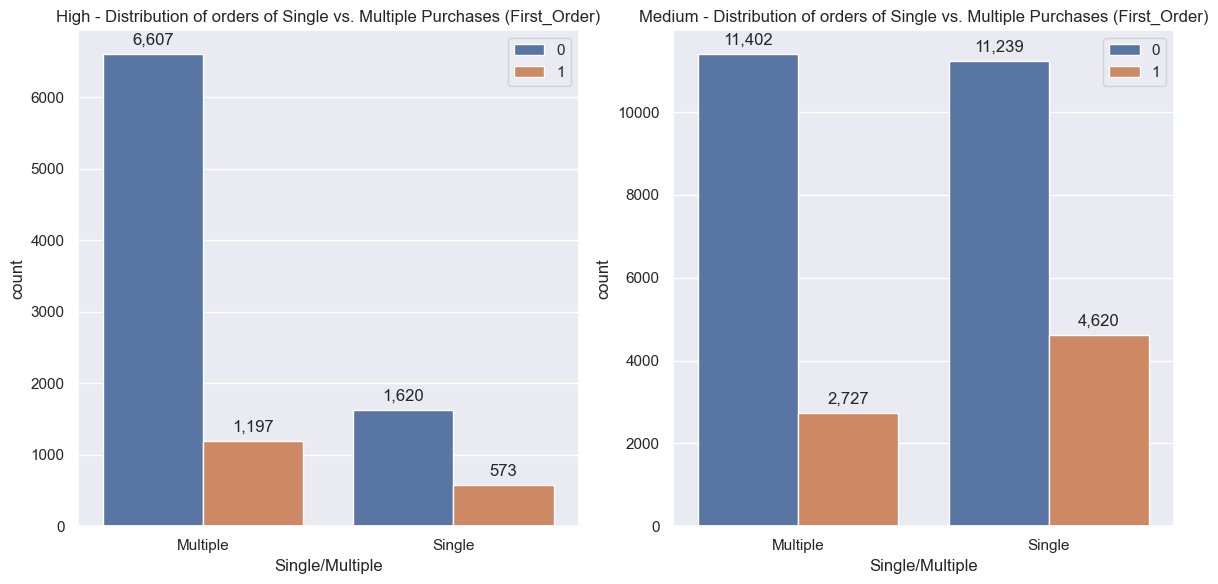

In [89]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Is_First_Order
sns.countplot(x='Single/Multiple', hue='Is_First_Order', data=high_value_customers, ax=axes[0])

axes[0].set_title('High - Distribution of orders of Single vs. Multiple Purchases (First_Order)')
axes[0].legend(loc='upper right')
annotate_countplot(axes[0])

sns.countplot(x='Single/Multiple', hue='Is_First_Order', data=Medium_value_customers, ax=axes[1])
axes[1].set_title('Medium - Distribution of orders of Single vs. Multiple Purchases (First_Order)')
axes[1].legend(loc='upper right')
annotate_countplot(axes[1])

plt.tight_layout()

High vs Medium - Payment type

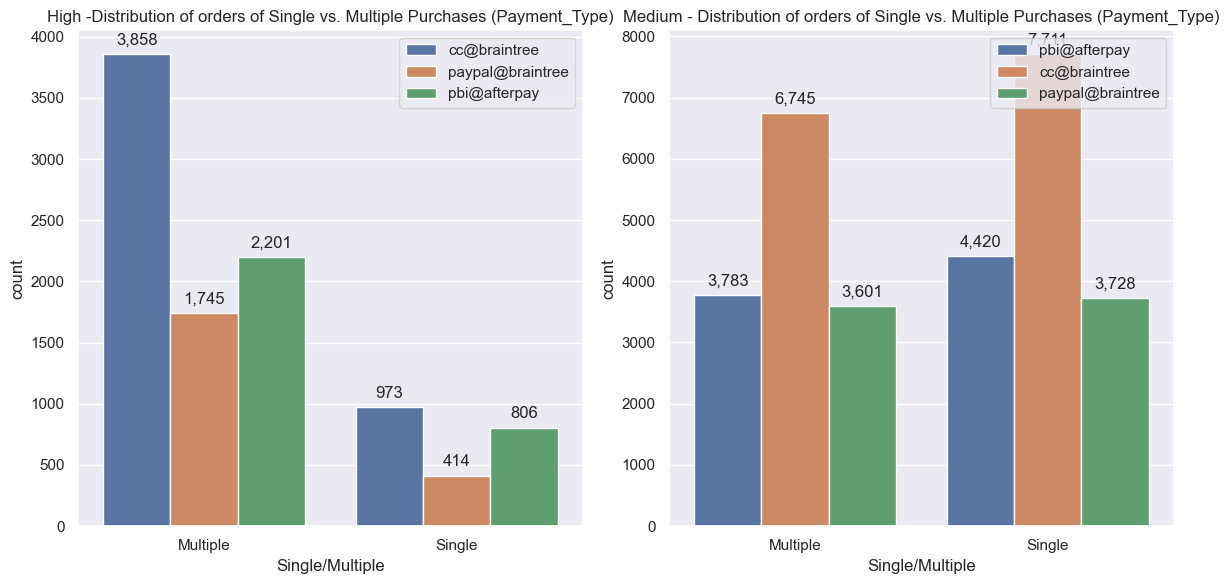

In [90]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 2: Payment_Type
sns.countplot(x='Single/Multiple', hue='Payment_Type', data=high_value_customers, ax=axes[0])
axes[0].set_title('High -Distribution of orders of Single vs. Multiple Purchases (Payment_Type)')
axes[0].legend(loc='upper right')
annotate_countplot(axes[0])

# Plot 2: Payment_Type
sns.countplot(x='Single/Multiple', hue='Payment_Type', data=Medium_value_customers, ax=axes[1])
axes[1].set_title('Medium - Distribution of orders of Single vs. Multiple Purchases (Payment_Type)')
axes[1].legend(loc='upper right')
annotate_countplot(axes[1])

plt.tight_layout()

High vs Medium - User Gender

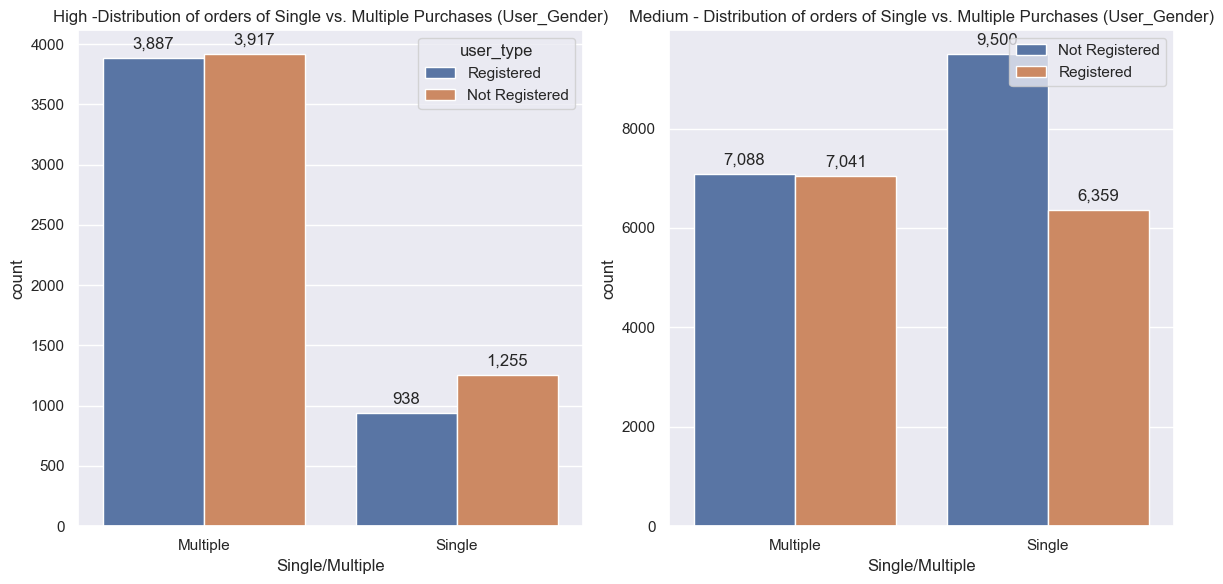

In [91]:
# Plot 3: User_Gender
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(x='Single/Multiple', hue='user_type', data=high_value_customers, ax=axes[0])
axes[0].set_title('High -Distribution of orders of Single vs. Multiple Purchases (User_Gender)')
annotate_countplot(axes[0])

sns.countplot(x='Single/Multiple', hue='user_type', data=Medium_value_customers, ax=axes[1])
axes[1].set_title('Medium - Distribution of orders of Single vs. Multiple Purchases (User_Gender)')
axes[1].legend(loc='upper right')
annotate_countplot(axes[1])

plt.tight_layout()

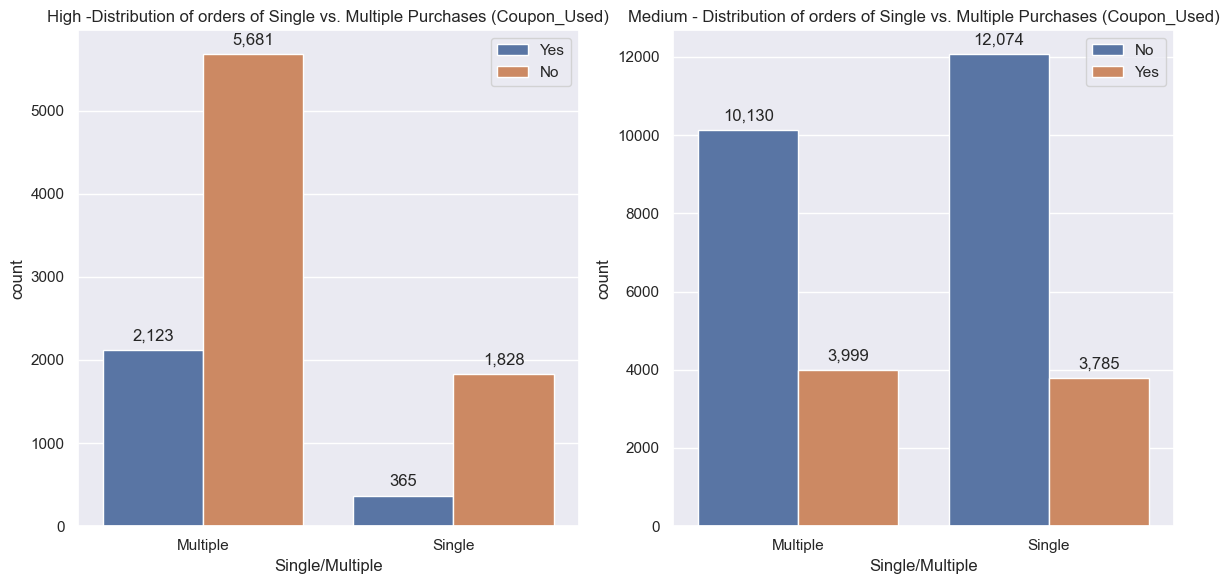

In [92]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 4: Coupon_Used
sns.countplot(x='Single/Multiple', hue='coupon_used', data=high_value_customers, ax=axes[0])
axes[0].set_title('High -Distribution of orders of Single vs. Multiple Purchases (Coupon_Used)')
axes[0].legend(loc='upper right')
annotate_countplot(axes[0])

sns.countplot(x='Single/Multiple', hue='coupon_used', data=Medium_value_customers, ax=axes[1])
axes[1].set_title('Medium - Distribution of orders of Single vs. Multiple Purchases (Coupon_Used)')
axes[1].legend(loc='upper right')
annotate_countplot(axes[1])


# Adjust layout
plt.tight_layout()

High vs Medium - City

In [93]:
segment_city = high_value_customers.groupby(['Single/Multiple', 'City'])['Revenue'].agg(['mean', 'count','sum']).reset_index().sort_values(by='count', ascending=False)
segment_country = high_value_customers.groupby(['Single/Multiple', 'Country'])['Revenue'].agg(['mean', 'count','sum']).reset_index().sort_values(by='count', ascending=False)
segment_province = high_value_customers.groupby(['Single/Multiple', 'Country_Province'])['Revenue'].agg(['mean', 'count','sum']).reset_index().sort_values(by='count', ascending=False)

segment_top10_city = segment_city.nlargest(10, 'sum').sort_values(by='count', ascending=False)

In [94]:
segment_city = Medium_value_customers.groupby(['Single/Multiple', 'City'])['Revenue'].agg(['mean', 'count','sum']).reset_index()
segment_country = Medium_value_customers.groupby(['Single/Multiple', 'Country'])['Revenue'].agg(['mean', 'count','sum']).reset_index()

segment_top10_city = segment_city.nlargest(10, 'sum')

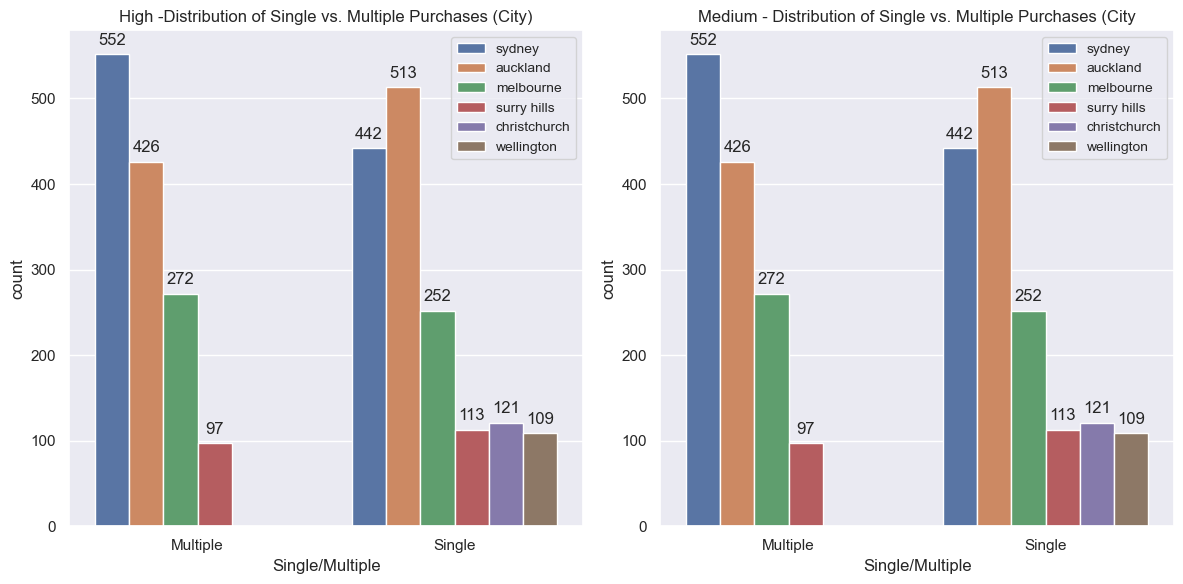

In [95]:
# Plot 2: City
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.barplot(x='Single/Multiple', y='count', hue='City', data=segment_top10_city, ax=axes[0])
axes[0].set_title('High -Distribution of Single vs. Multiple Purchases (City)')
axes[0].legend(loc='upper right', fontsize='small')
annotate_countplot(axes[0])

sns.barplot(x='Single/Multiple', y='count', hue='City', data=segment_top10_city, ax=axes[1])
axes[1].set_title('Medium - Distribution of Single vs. Multiple Purchases (City')
axes[1].legend(loc='upper right',fontsize='small')
annotate_countplot(axes[1])

plt.tight_layout()

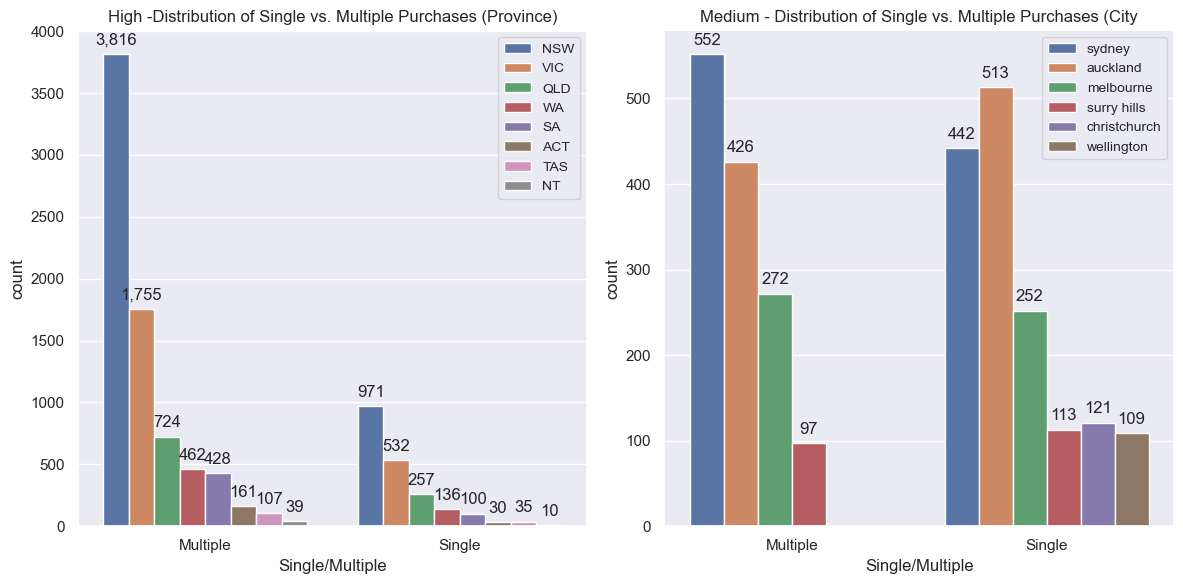

In [96]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.barplot(x='Single/Multiple', y='count', hue='Country_Province', data=segment_province, ax=axes[0])
axes[0].set_title('High -Distribution of Single vs. Multiple Purchases (Province)')
axes[0].legend(loc='upper right', fontsize='small')
annotate_countplot(axes[0])

sns.barplot(x='Single/Multiple', y='count', hue='City', data=segment_top10_city, ax=axes[1])
axes[1].set_title('Medium - Distribution of Single vs. Multiple Purchases (City')
axes[1].legend(loc='upper right',fontsize='small')
annotate_countplot(axes[1])

plt.tight_layout()


In [97]:
high_unique_prod = high_value_customers.groupby(['unique_product'])['Revenue'].agg(['mean', 'count','sum']).reset_index()

In [98]:
medium_unique_prod = Medium_value_customers.groupby(['unique_product'])['Revenue'].agg(['mean', 'count','sum']).reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


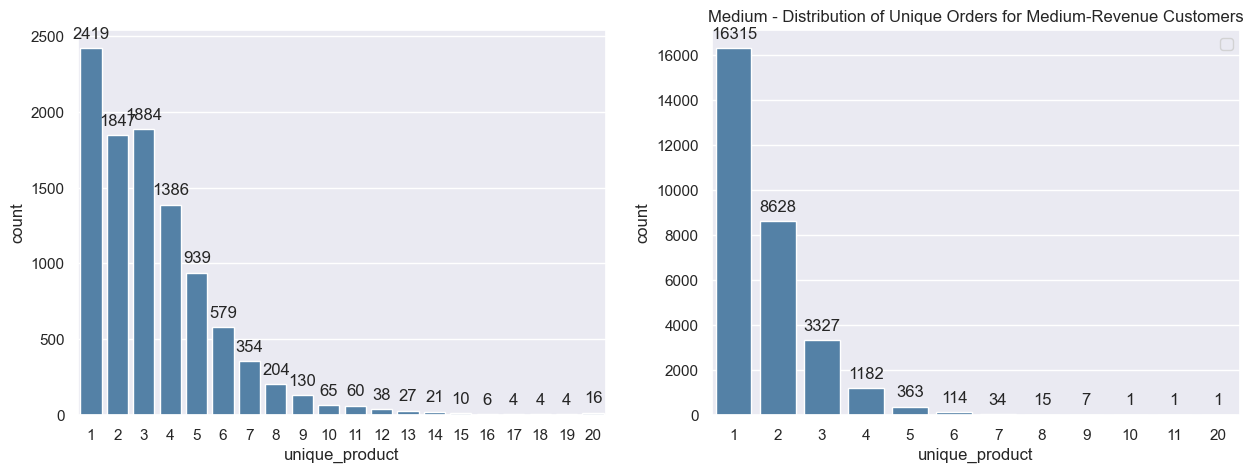

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.countplot(x='unique_product', data=high_value_customers,color='steelblue', ax=axes[0])
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=12)
plt.title('Medium - Distribution of Unique Orders for Medium-Revenue Customers')
plt.legend(loc='upper right')



sns.countplot(x='unique_product', data=Medium_value_customers,color='steelblue',ax=axes[1])
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=12)
plt.title('Medium - Distribution of Unique Orders for Medium-Revenue Customers')
plt.legend(loc='upper right')


Low-Value Customers

In [100]:
low_value_customers=sales[sales['Revenue_Segment']=='Low-Value Customers']

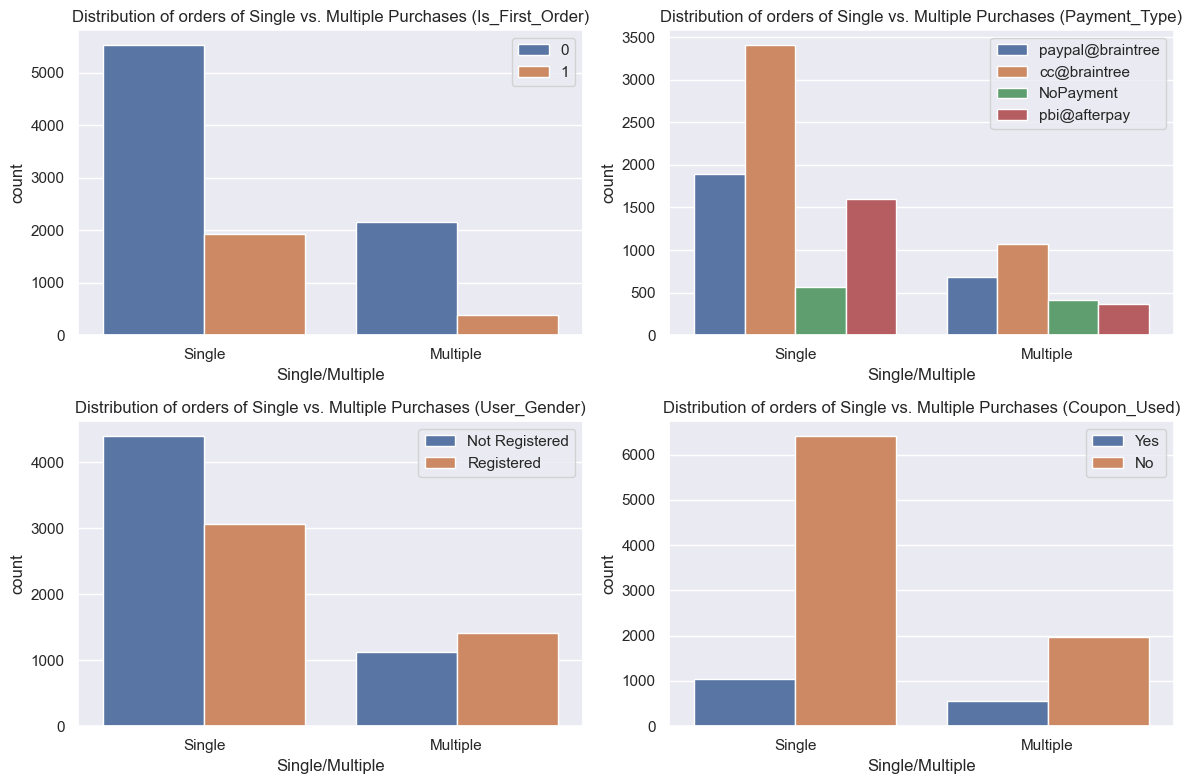

In [101]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot 1: Is_First_Order
sns.countplot(x='Single/Multiple', hue='Is_First_Order', data=low_value_customers, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of orders of Single vs. Multiple Purchases (Is_First_Order)')
axes[0,0].legend(loc='upper right')

# Plot 2: Payment_Type
sns.countplot(x='Single/Multiple', hue='Payment_Type', data=low_value_customers, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of orders of Single vs. Multiple Purchases (Payment_Type)')
axes[0,1].legend(loc='upper right')

# Plot 3: User_Gender
sns.countplot(x='Single/Multiple', hue='user_type', data=low_value_customers, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of orders of Single vs. Multiple Purchases (User_Gender)')
axes[1,0].legend(loc='upper right')
# Plot 4: Coupon_Used
sns.countplot(x='Single/Multiple', hue='coupon_used', data=low_value_customers, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of orders of Single vs. Multiple Purchases (Coupon_Used)')
axes[1,1].legend(loc='upper right')


# Adjust layout
plt.tight_layout()

In [102]:
segment_city = low_value_customers.groupby(['Single/Multiple', 'City'])['Revenue'].agg(['mean', 'count','sum']).reset_index()
segment_country = low_value_customers.groupby(['Single/Multiple', 'Country'])['Revenue'].agg(['mean', 'count','sum']).reset_index()

segment_top10_city = segment_city.nlargest(10, 'sum')

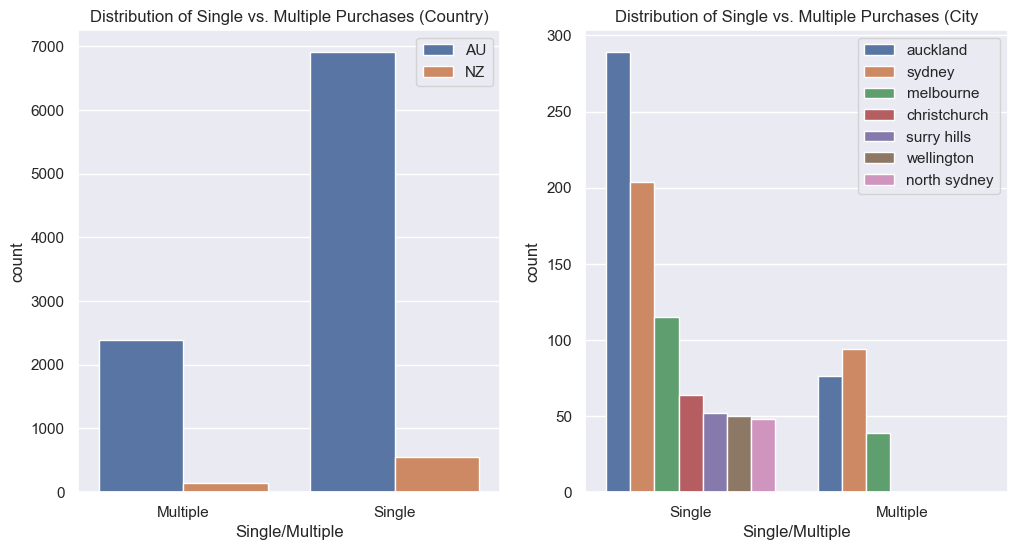

In [103]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Country
sns.barplot(x='Single/Multiple', y='count', hue='Country', data=segment_country, ax=axes[0])
axes[0].set_title('Distribution of Single vs. Multiple Purchases (Country)')
axes[0].legend(loc='upper right')
# Plot 2: City

sns.barplot(x='Single/Multiple', y='count', hue='City', data=segment_top10_city, ax=axes[1])
axes[1].set_title('Distribution of Single vs. Multiple Purchases (City')
axes[1].legend(loc='upper right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


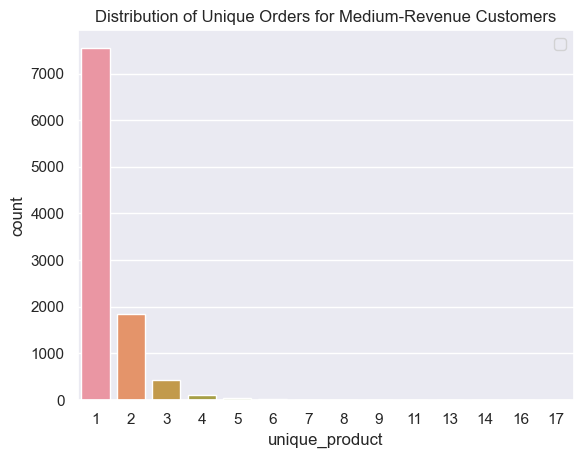

In [104]:
sns.countplot(x='unique_product', data=low_value_customers)
plt.title('Distribution of Unique Orders for Medium-Revenue Customers')
plt.legend(loc='upper right')

# ADDITIONAL: Using RandomForest to predict if customers will purchase single or multiple items

In [414]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,confusion_matrix,classification_report


Dropping columns that are not useful for the model. Dropping Revenue as well since it is an obvious feature for revenue segmentation. I want the model to classify according to customer purchase characteristics.

In [380]:
sales_subset = sales.drop(['Revenue_Segment','User_Gender','age','Revenue','timestamp','user ID','ip_address','Product_ID','Number_of_Products','Order_Coupon_Code','Product_List','date','age_category','User_Birthday','unique_product','time_of_day','day_of_week','City','Country','total_products'],axis=1)

In [381]:
sales_subset

,Is_First_Order,Payment_Type,Country_Province,Single/Multiple,coupon_used,user_type
3383,1,paypal@braintree,VIC,Single,Yes,Not Registered
32538,0,pbi@afterpay,VIC,Multiple,No,Not Registered
23333,0,cc@braintree,VIC,Single,No,Not Registered
10217,0,cc@braintree,NaN,Single,No,Not Registered
8010,0,paypal@braintree,NSW,Single,No,Not Registered
...,...,...,...,...,...,...
5559,1,pbi@afterpay,QLD,Single,No,Registered
120,0,cc@braintree,NaN,Single,No,Not Registered
25726,0,paypal@braintree,NaN,Multiple,No,Not Registered
40591,0,pbi@afterpay,QLD,Multiple,No,Registered


In [382]:
#encode categorical variables into numerical
sales_encoded = pd.get_dummies(sales_subset, columns=['Payment_Type','coupon_used','user_type','Is_First_Order','Country_Province'],drop_first = True)

C:\Users\clyve\AppData\Local\Temp\ipykernel_27384\1020774609.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  sales_encoded = pd.get_dummies(sales_subset, columns=['Payment_Type','coupon_used','user_type','Is_First_Order','Country_Province'],drop_first = True)


In [383]:
sales_encoded

,Single/Multiple,Payment_Type_cc@braintree,Payment_Type_paypal@braintree,Payment_Type_pbi@afterpay,coupon_used_Yes,user_type_Registered,Is_First_Order_1,Country_Province_NSW,Country_Province_NT,Country_Province_QLD,Country_Province_SA,Country_Province_TAS,Country_Province_VIC,Country_Province_WA
3383,Single,0,1,0,1,0,1,0,0,0,0,0,1,0
32538,Multiple,0,0,1,0,0,0,0,0,0,0,0,1,0
23333,Single,1,0,0,0,0,0,0,0,0,0,0,1,0
10217,Single,1,0,0,0,0,0,0,0,0,0,0,0,0
8010,Single,0,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5559,Single,0,0,1,0,1,1,0,0,1,0,0,0,0
120,Single,1,0,0,0,0,0,0,0,0,0,0,0,0
25726,Multiple,0,1,0,0,0,0,0,0,0,0,0,0,0
40591,Multiple,0,0,1,0,1,0,0,0,1,0,0,0,0


In [384]:
#Separate the dataset into labels (y) and features (X).
X=sales_encoded.drop('Single/Multiple',axis=1)
y=sales_encoded['Single/Multiple']


In [385]:
#Split into train, validation and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)

In [391]:
# Determine set of hyperparameters.
cv_params = {'n_estimators' : [50,100], 
              'max_depth' : [10,50],        
              'min_samples_leaf' : [0.5,1], 
              'min_samples_split' : [0.001, 0.01],
              'max_features' : ["sqrt"], 
              'max_samples' : [.5,.9]}

In [407]:
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [392]:
#This will serve as a custom split that will identify which data points from the train set should be treated as validation data during GridSearch.
split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

In [393]:
clf=RandomForestClassifier(n_estimators=100,random_state=42)

In [394]:
clf_val = GridSearchCV(clf, cv_params, cv=custom_split, scoring=scoring, refit='f1', n_jobs = -1, verbose = 1)

In [395]:
#fit the model
clf_val.fit(X_train,y_train)

Fitting 1 folds for each of 32 candidates, totalling 32 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 50], 'max_features': ['sqrt'],
                         'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [0.5, 1],
                         'min_samples_split': [0.001, 0.01],
                         'n_estimators': [50, 100]},
             refit='f1', verbose=1)

In [396]:
clf_val.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 0.01,
 'n_estimators': 50}

In [397]:
# Use optimal parameters on GridSearchCV.

clf_opt = RandomForestClassifier(max_depth= 10,
 max_features= 'sqrt',
 max_samples= 0.5,
 min_samples_leaf= 1,min_samples_split= 0.01,
 n_estimators= 50, random_state = 0)

In [398]:
# Fit the optimal model.
clf_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_samples=0.5, min_samples_split=0.01,
                       n_estimators=50, random_state=0)

In [399]:
y_pred = clf_opt.predict(X_test)

Model Performance

1. True positives (TP): These are correctly predicted positive values, which means the value of actual and predicted classes are positive. 

2. True negatives (TN): These are correctly predicted negative values, which means the value of the actual and predicted classes are negative.

3. False positives (FP): This occurs when the value of the actual class is negative and the value of the predicted class is positive.

4. False negatives (FN): This occurs when the value of the actual class is positive and the value of the predicted class in negative. 



- Accuracy (TP+TN/TP+FP+FN+TN): The ratio of correctly predicted observations to total observations. 
 
- Precision (TP/TP+FP): The ratio of correctly predicted positive observations to total predicted positive observations. 

- Recall (Sensitivity, TP/TP+FN): The ratio of correctly predicted positive observations to all observations in actual class.

- F1 score: The harmonic average of precision and recall, which takes into account both false positives and false negatives. 

Model Evalutation

In [415]:
target_names=['Single','Multiple']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

      Single       0.55      0.54      0.54      6102
    Multiple       0.57      0.58      0.58      6394

    accuracy                           0.56     12496
   macro avg       0.56      0.56      0.56     12496
weighted avg       0.56      0.56      0.56     12496



In [416]:

feature_importances = clf_opt.feature_importances_
# Create a DataFrame
df_feature_importances = pd.DataFrame({'Features': X_train.columns, 'Importance': feature_importances})
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)



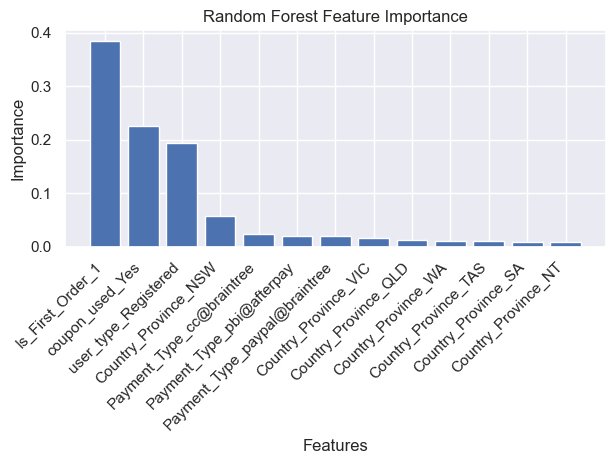

In [417]:
plt.bar(df_feature_importances['Features'], df_feature_importances['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.title("Random Forest Feature Importance")
plt.tight_layout()

* The random forest model classified single/multiple purchases with 56% accuracy. For Single purchases, the precision is 55% and the recall is 54%. F1 score is 54%. The model had a higher overall score when classifying multiple purchases. Precision is 57%, recall is 58% and f1 score is 57%. The model is not able to classify purchase types as well as I hoped.
* The goal was to classify customers with the interest of learning about the factors that are most important for higher sales using single/multiple purchases as the outcome variable.
* By a wide margin, First Orders is rated the most important factor. The next factor is regarding coupon usage and whether the user is registered. Likely these 3 variables are correlated as first orders could have coupons with higher discounts and only those that register are able to get these coupons for their first purchase. 
* Country province and payment gateway did not score as important 
